# Librerías

In [2]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
import optuna


# Modelos a probar
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

import gc
import warnings
warnings.filterwarnings('ignore')

# Archivos base

In [ ]:
sales = pl.read_csv('sales_train_evaluation.csv').lazy()
calendar = pl.read_csv('calendar.csv').lazy()
sells_prices = pl.read_csv('sell_prices.csv').lazy()

# Transformaciones

In [4]:
columnas_identificadoras = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# Aplicamos melt para pivotar las columnas 'd_n'
sales_long = sales.unpivot(
    index=columnas_identificadoras,
    variable_name='d', 
    value_name='cantidad'
)

In [5]:
sales_long.head().collect()

id,item_id,dept_id,cat_id,store_id,state_id,d,cantidad
str,str,str,str,str,str,str,i64
"""HOBBIES_1_001_CA_1_evaluation""","""HOBBIES_1_001""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0
"""HOBBIES_1_002_CA_1_evaluation""","""HOBBIES_1_002""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0
"""HOBBIES_1_003_CA_1_evaluation""","""HOBBIES_1_003""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0
"""HOBBIES_1_004_CA_1_evaluation""","""HOBBIES_1_004""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0
"""HOBBIES_1_005_CA_1_evaluation""","""HOBBIES_1_005""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0


In [6]:
sales_long = sales_long.join(
    calendar,
    left_on= ['d'],
    right_on= ['d'],
    how= 'inner'
)

sales_long = sales_long.select([
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'cantidad',
 'date',
 'd',
 'wm_yr_wk',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI'])


In [7]:
sales_long = sales_long.join(
    sells_prices,
    left_on= ['item_id', 'store_id', 'wm_yr_wk'],
    right_on= ['item_id', 'store_id', 'wm_yr_wk'],
    how= 'inner'
)

In [8]:
sales_long = sales_long.with_columns((pl.col("sell_price") + pl.col("cantidad")).alias("ventasme"))

In [9]:
sales_long = sales_long.with_columns(pl.col('date').cast(pl.Date)).sort(["item_id", "store_id", "date"])

sales_long = sales_long.with_columns(
    dias_desde_ultima_compra = (
        pl.col("date") - 
        pl.when(pl.col("cantidad") > 0)
        .then(pl.col("date"))
        .otherwise(None)
        .forward_fill()
        .shift(1)
        .over(["item_id", "store_id"])
    ).dt.total_days()
)

sales_long = sales_long.with_columns(
    pl.col("dias_desde_ultima_compra").fill_null(-1)
)

In [10]:
sales_long = sales_long.with_columns(
        pl.when(pl.col('cantidad') > 0)
        .then(1)
        .otherwise(0)
        .alias('compra')
)

In [11]:
group_cols = ["item_id", "store_id"]

sales_long = sales_long.with_columns(
        pl.when(pl.col('cantidad') > 0)
        .then(pl.col('cantidad'))
        .otherwise(None)
        .shift(1)
        .over(group_cols)
        .alias('cantidad_ultima_compra')
)

In [12]:
compras = (
    sales_long.filter(pl.col("cantidad") > 0)  # Solo registros con ventas
    .sort(["item_id", "store_id", "date"])  # Orden cronológico por grupo
    .with_columns(
        # Calculamos la diferencia de días entre registros consecutivos por producto/tienda
        diff_dias = pl.col("date")
        .diff()
        .dt.total_days()
        .over(["item_id", "store_id"])
    )
    .group_by(["item_id", "store_id"])
    .agg(
        # Calculamos el promedio ignorando los nulos (la primera compra de cada grupo)
        pl.col("diff_dias").mean().alias("promedio_dias_entre_compras"),
        pl.col('cantidad').mean().alias("promedio_cantidad")
    )
)

compras.head(5).collect()

item_id,store_id,promedio_dias_entre_compras,promedio_cantidad
str,str,f64,f64
"""HOUSEHOLD_1_057""","""TX_2""",8.085973,1.373874
"""FOODS_1_018""","""TX_2""",1.078977,8.555864
"""FOODS_1_087""","""TX_3""",1.098692,4.167558
"""FOODS_2_003""","""TX_1""",2.25844,1.904651
"""HOUSEHOLD_1_253""","""TX_1""",3.932432,1.47651


In [13]:
sales_long = sales_long.join(
    compras,
    on = ['item_id', 'store_id'],
    how = 'inner'
)

In [27]:
sales_long.schema

Schema([('item_id', String),
        ('dept_id', String),
        ('cat_id', String),
        ('store_id', String),
        ('state_id', String),
        ('cantidad', Int64),
        ('date', Date),
        ('d', String),
        ('wm_yr_wk', Int64),
        ('event_name_1', String),
        ('event_type_1', String),
        ('event_name_2', String),
        ('event_type_2', String),
        ('snap_CA', Int64),
        ('snap_TX', Int64),
        ('snap_WI', Int64),
        ('sell_price', Float64),
        ('ventasme', Float64),
        ('dias_desde_ultima_compra', Int64),
        ('compra', Int32),
        ('cantidad_ultima_compra', Int64),
        ('promedio_dias_entre_compras', Float64),
        ('promedio_cantidad', Float64)])

# EDA

In [15]:
sales_long = sales_long.collect().to_pandas()

In [29]:
sales_long.head(5)

,item_id,dept_id,cat_id,store_id,state_id,cantidad,date,d,wm_yr_wk,event_name_1,...,snap_CA,snap_TX,snap_WI,sell_price,ventasme,dias_desde_ultima_compra,compra,cantidad_ultima_compra,promedio_dias_entre_compras,promedio_cantidad
0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,d_1,11101,NaN,...,0,0,0,2.0,5.0,-1,1,NaN,2.292308,1.803783
1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,d_2,11101,NaN,...,0,0,0,2.0,2.0,1,0,3.0,2.292308,1.803783
2,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,d_3,11101,NaN,...,0,0,0,2.0,2.0,2,0,NaN,2.292308,1.803783
3,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,d_4,11101,NaN,...,1,1,0,2.0,3.0,3,1,NaN,2.292308,1.803783
4,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,d_5,11101,NaN,...,1,0,1,2.0,6.0,1,1,1.0,2.292308,1.803783


## Tienda más importante de cada estado

In [30]:
sales_long.groupby(['store_id', 'state_id']).agg({'ventasme' : 'sum'}).reset_index()

,store_id,state_id,ventasme
0,CA_1,CA,28961288.56
1,CA_2,CA,25201678.75
2,CA_3,CA,32229822.44
3,CA_4,CA,24747426.08
4,TX_1,TX,26673041.06
5,TX_2,TX,28315301.34
6,TX_3,TX,26982127.24
7,WI_1,WI,25588354.89
8,WI_2,WI,27331464.62
9,WI_3,WI,27618510.37


In [31]:
tienda_x_estado = sales_long.groupby(['store_id', 'state_id']).agg({'ventasme' : 'sum'}).reset_index()

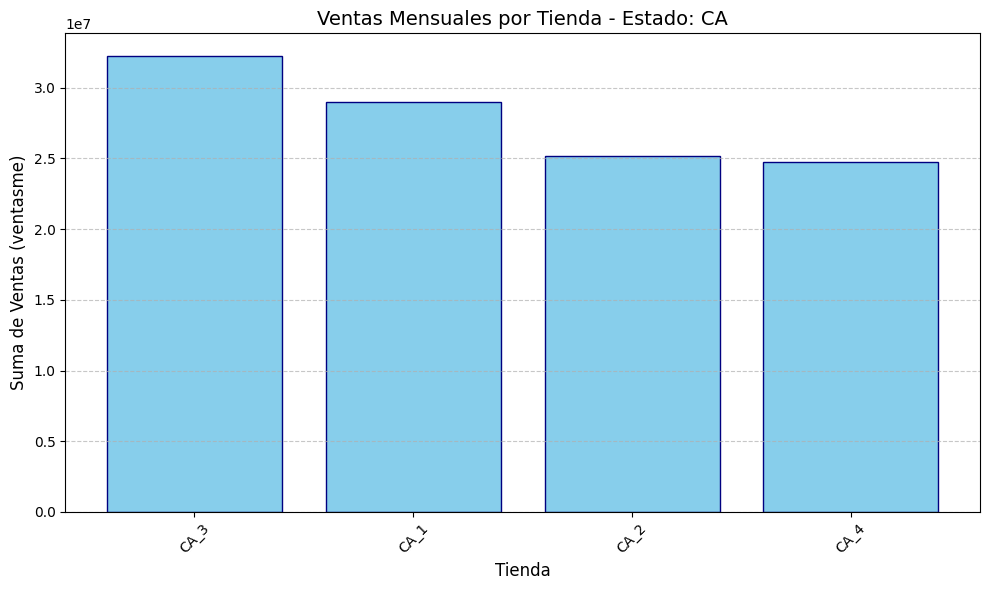

----------------------------------------------------------------------------------------------------------------------------------


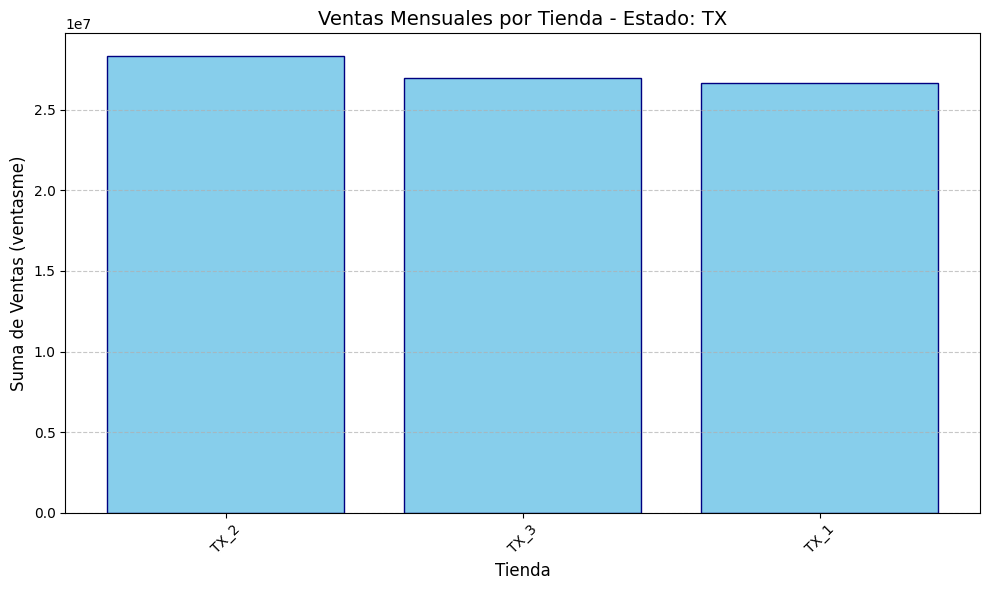

----------------------------------------------------------------------------------------------------------------------------------


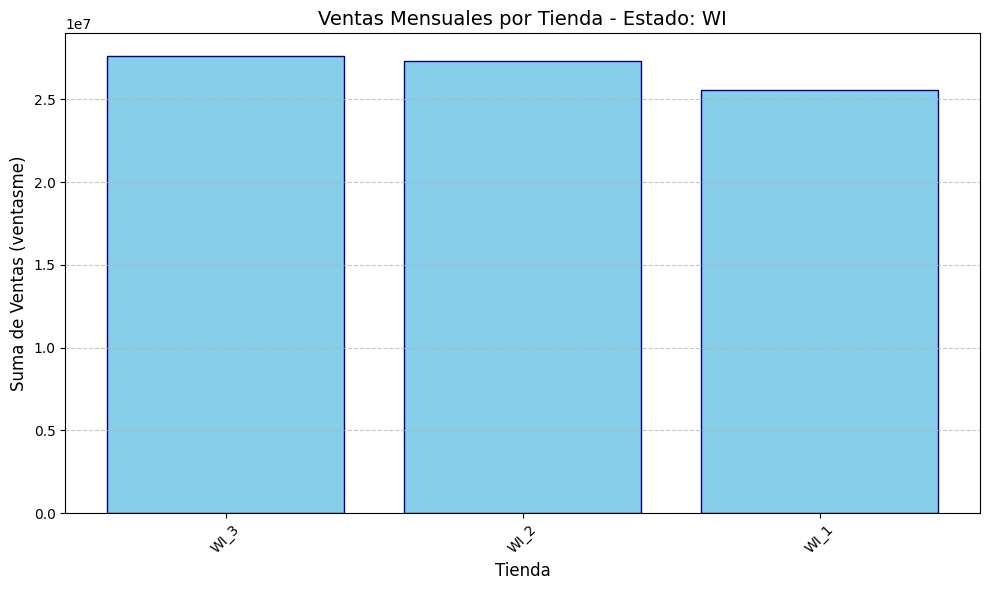

----------------------------------------------------------------------------------------------------------------------------------
Gráficas generadas exitosamente.


In [32]:
estados = tienda_x_estado['state_id'].unique()

# 4. Generar un gráfico por cada tienda
for estado in estados:
    # Filtrar datos para la tienda actual
    data_estado = tienda_x_estado[tienda_x_estado['state_id'] == estado]
    
    # Ordenar por ventas para una mejor visualización (opcional)
    data_estado = data_estado.sort_values(by='ventasme', ascending=False)
    
    # Crear la figura
    plt.figure(figsize=(10, 6))
    plt.bar(data_estado['store_id'], data_estado['ventasme'], color='skyblue', edgecolor='navy')
    
    # Añadir títulos y etiquetas
    plt.title(f'Ventas Mensuales por Tienda - Estado: {estado}', fontsize=14)
    plt.xlabel('Tienda', fontsize=12)
    plt.ylabel('Suma de Ventas (ventasme)', fontsize=12)
    plt.xticks(rotation=45) # Rotar etiquetas si son largas
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar diseño para que no se corten las etiquetas
    plt.tight_layout()
    plt.show()
    # Guardar el gráfico
    print("-" * 130) # Cerrar la figura para liberar memoria

print("Gráficas generadas exitosamente.")

## Categorías más importantes de cada tienda

In [34]:
cat_x_tienda = sales_long.groupby(['store_id', 'cat_id']).agg({'ventasme' : 'sum'}).reset_index()

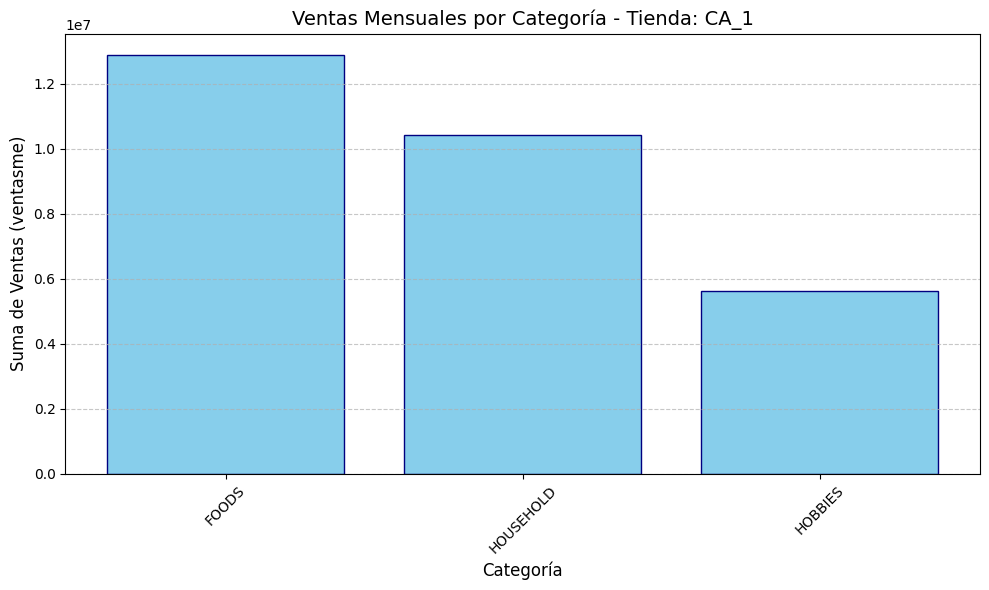

----------------------------------------------------------------------------------------------------------------------------------


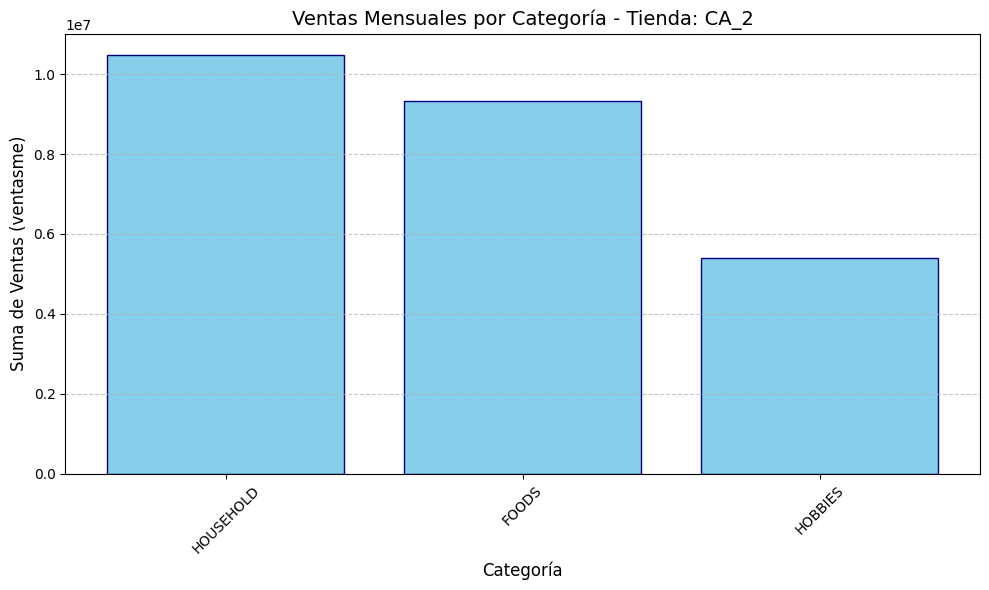

----------------------------------------------------------------------------------------------------------------------------------


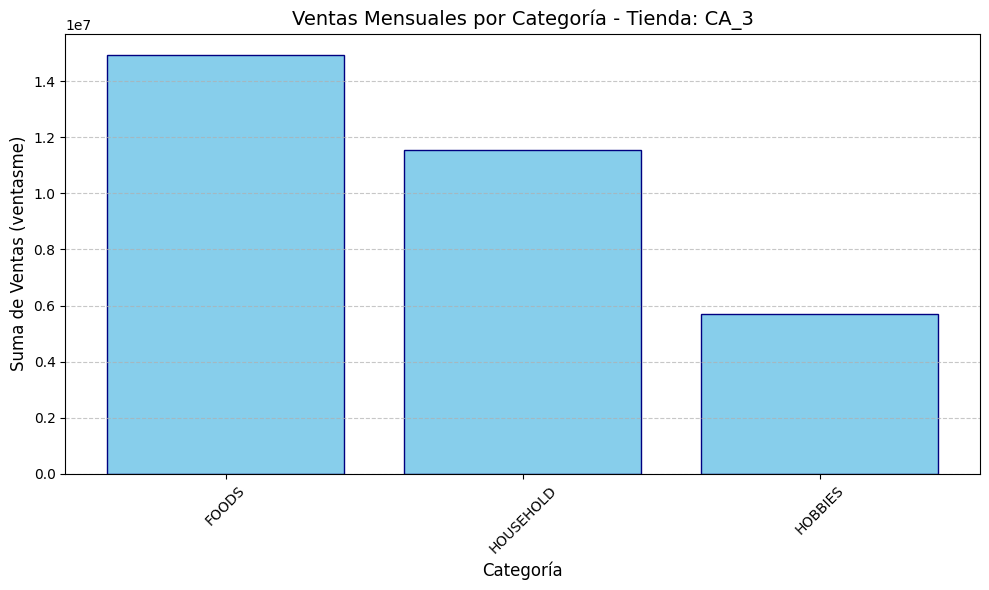

----------------------------------------------------------------------------------------------------------------------------------


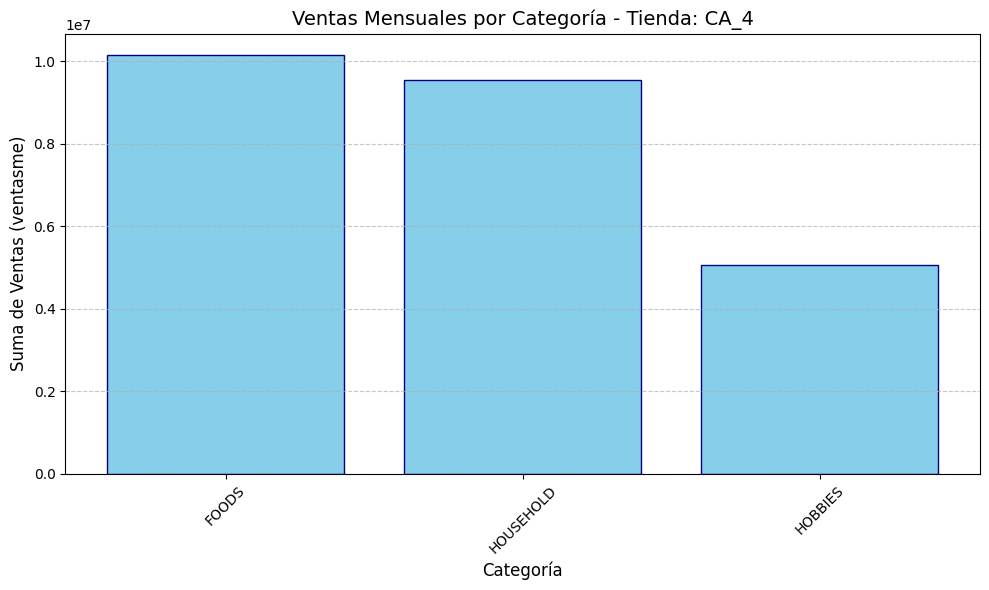

----------------------------------------------------------------------------------------------------------------------------------


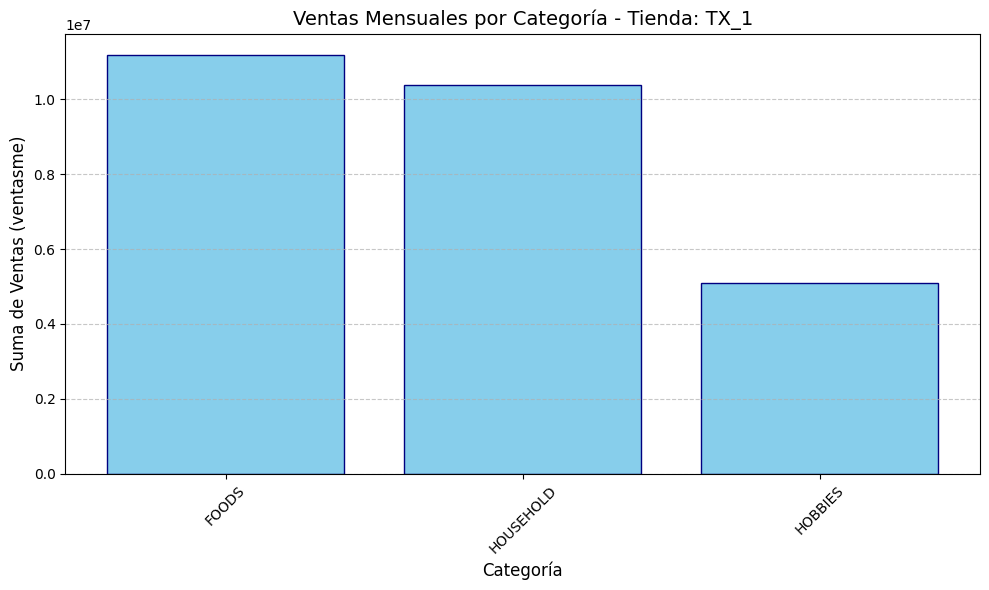

----------------------------------------------------------------------------------------------------------------------------------


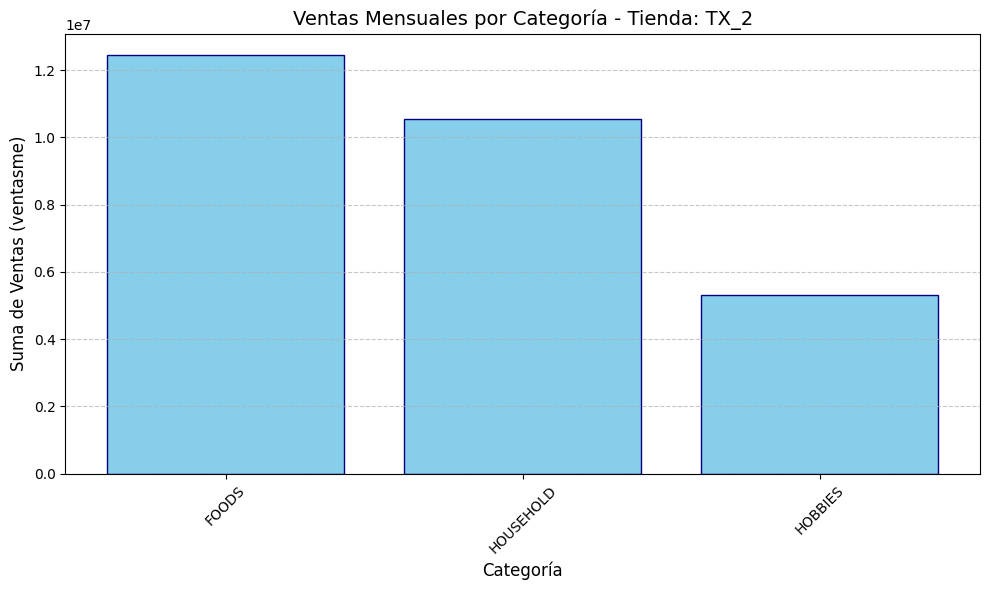

----------------------------------------------------------------------------------------------------------------------------------


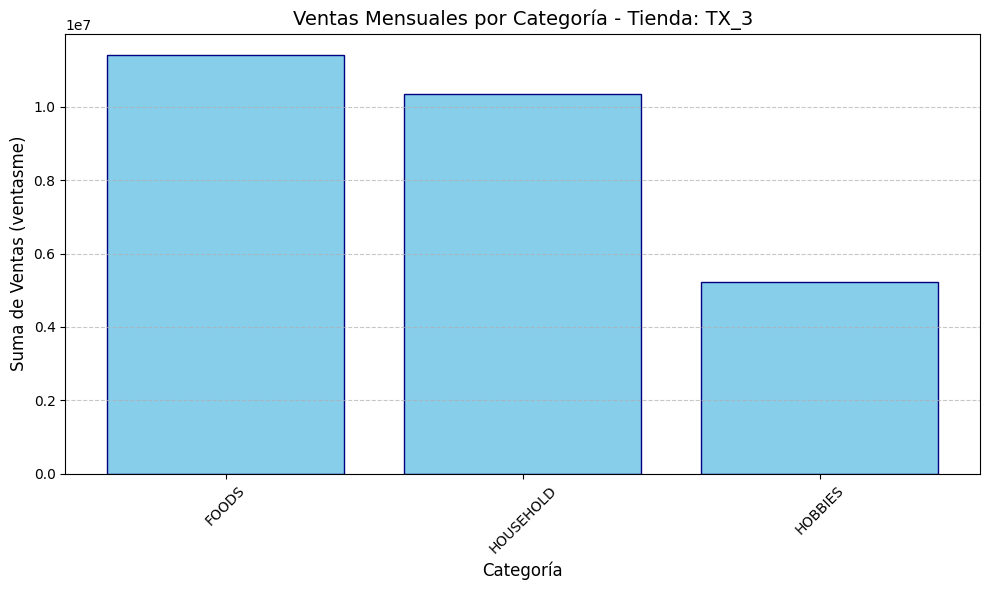

----------------------------------------------------------------------------------------------------------------------------------


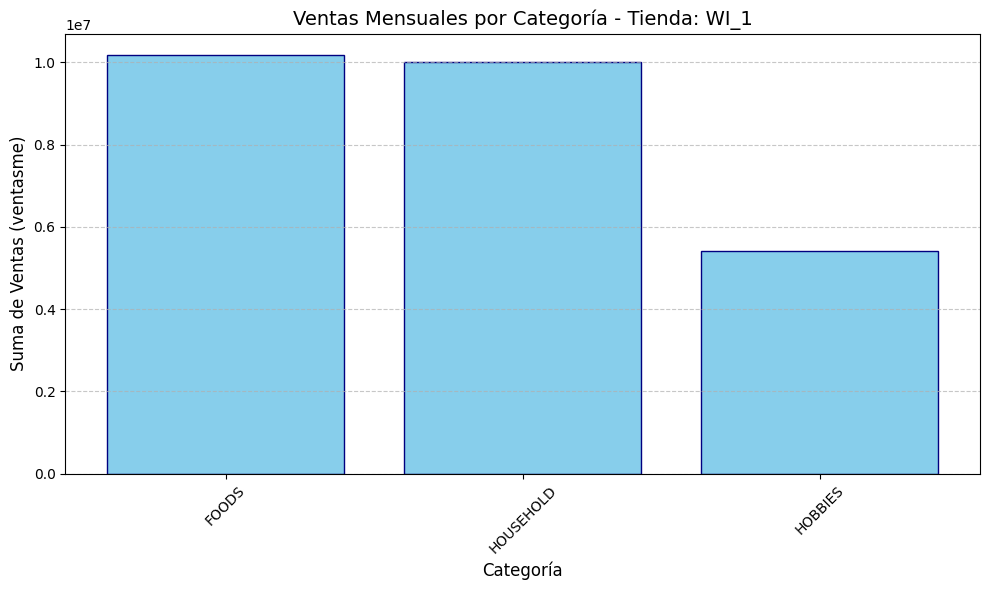

----------------------------------------------------------------------------------------------------------------------------------


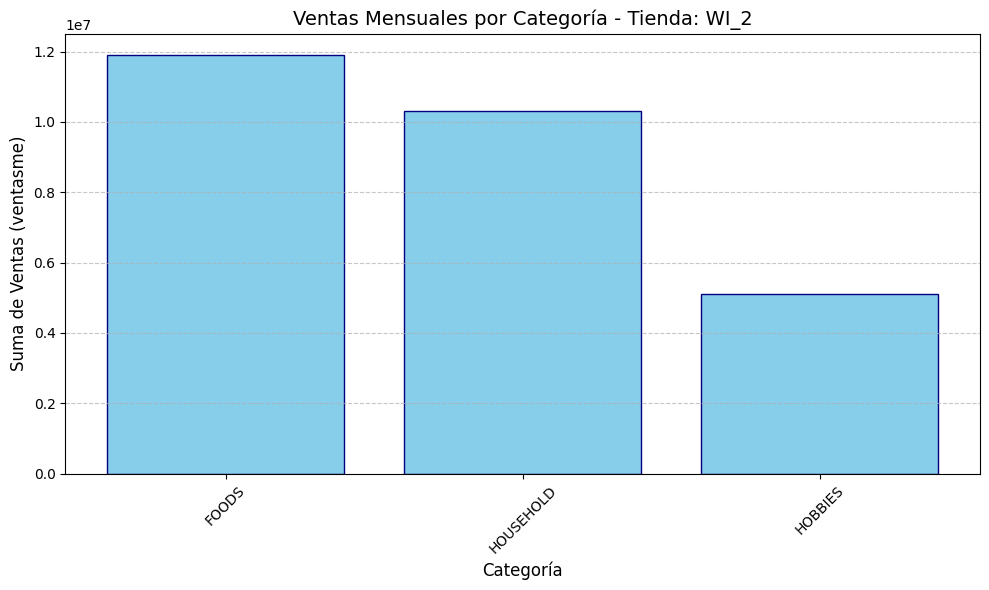

----------------------------------------------------------------------------------------------------------------------------------


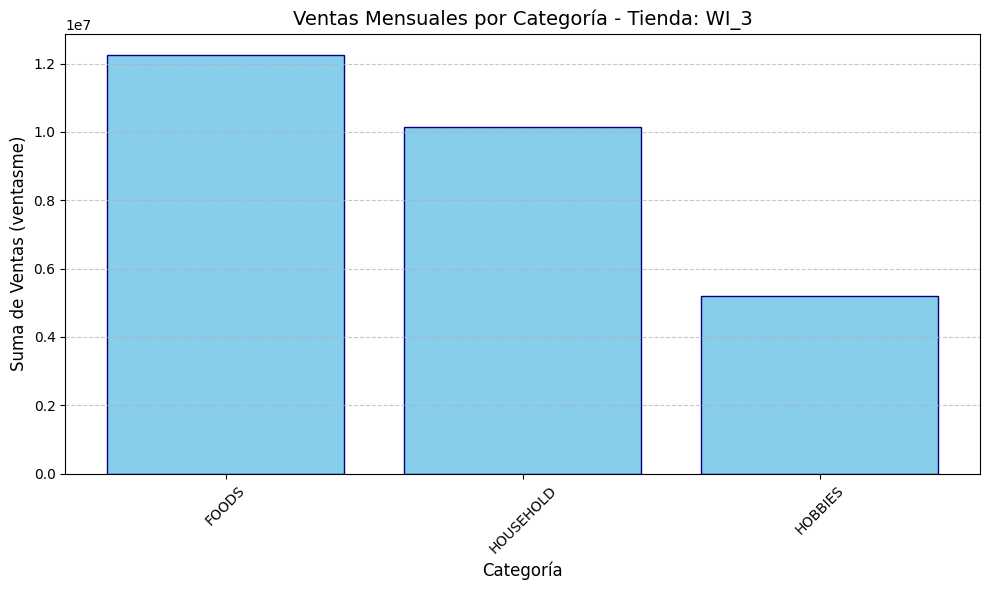

----------------------------------------------------------------------------------------------------------------------------------
Gráficas generadas exitosamente.


In [35]:
tiendas = cat_x_tienda['store_id'].unique()

# 4. Generar un gráfico por cada tienda
for tienda in tiendas:
    # Filtrar datos para la tienda actual
    data_tienda = cat_x_tienda[cat_x_tienda['store_id'] == tienda]
    
    # Ordenar por ventas para una mejor visualización (opcional)
    data_tienda = data_tienda.sort_values(by='ventasme', ascending=False)
    
    # Crear la figura
    plt.figure(figsize=(10, 6))
    plt.bar(data_tienda['cat_id'], data_tienda['ventasme'], color='skyblue', edgecolor='navy')
    
    # Añadir títulos y etiquetas
    plt.title(f'Ventas Mensuales por Categoría - Tienda: {tienda}', fontsize=14)
    plt.xlabel('Categoría', fontsize=12)
    plt.ylabel('Suma de Ventas (ventasme)', fontsize=12)
    plt.xticks(rotation=45) # Rotar etiquetas si son largas
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar diseño para que no se corten las etiquetas
    plt.tight_layout()
    plt.show()
    # Guardar el gráfico
    print("-" * 130) # Cerrar la figura para liberar memoria

print("Gráficas generadas exitosamente.")

## Departamentos por tienda

In [36]:
dept_x_tienda = sales_long.groupby(['store_id', 'dept_id']).agg({'ventasme' : 'sum'}).reset_index()

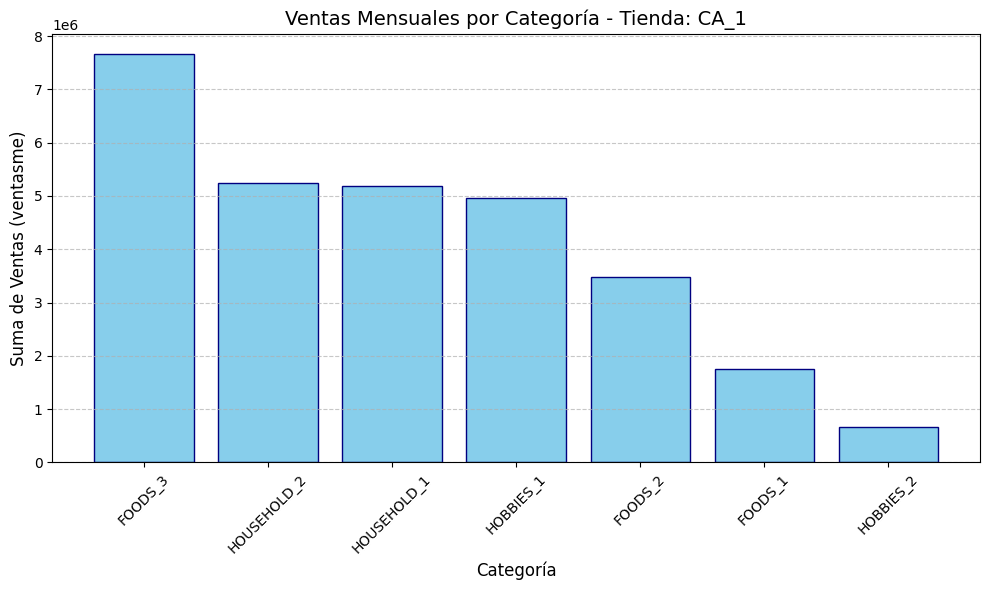

--------------------------------------------------------------------------------------------------------------


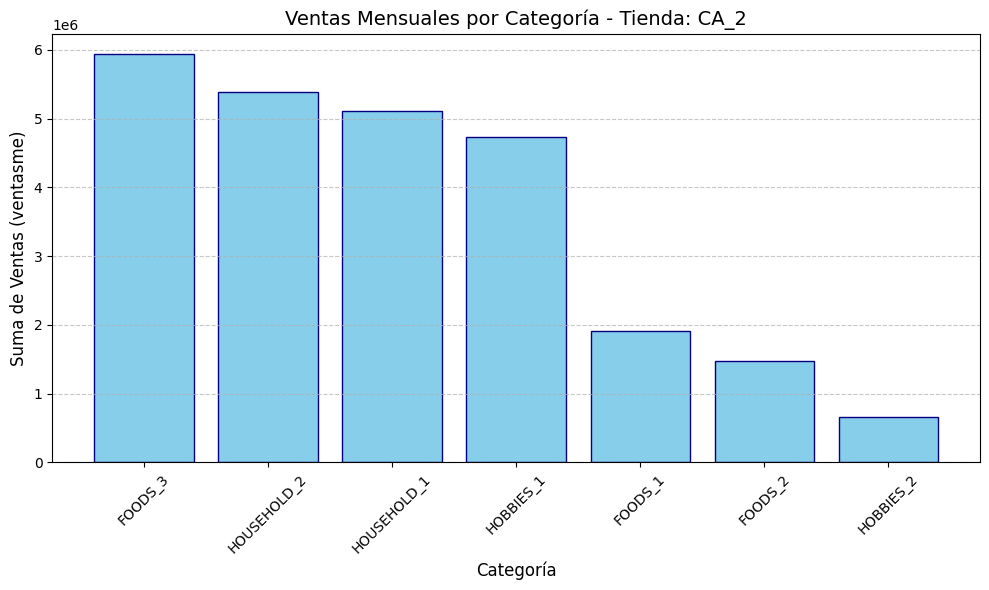

--------------------------------------------------------------------------------------------------------------


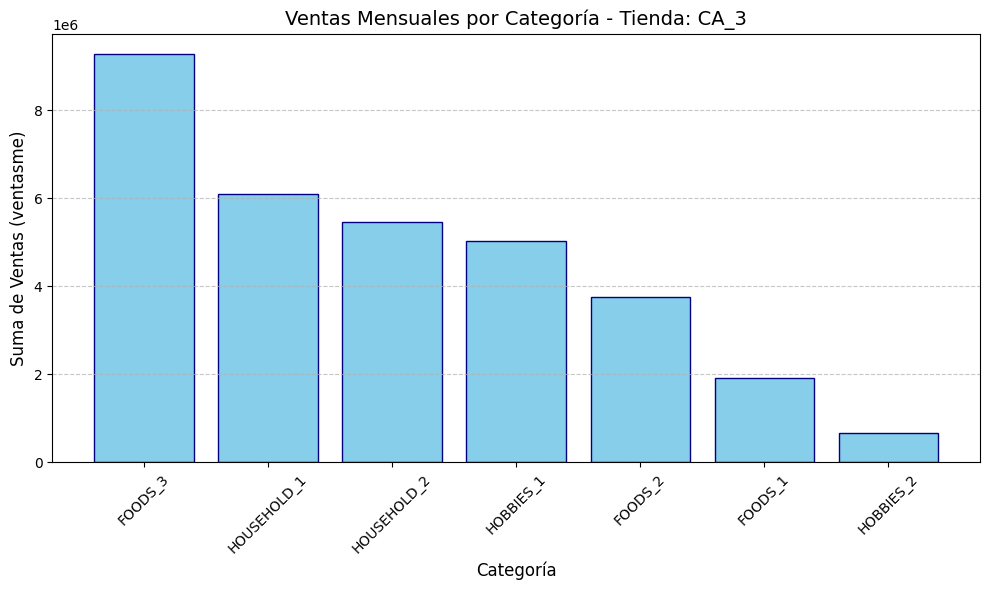

--------------------------------------------------------------------------------------------------------------


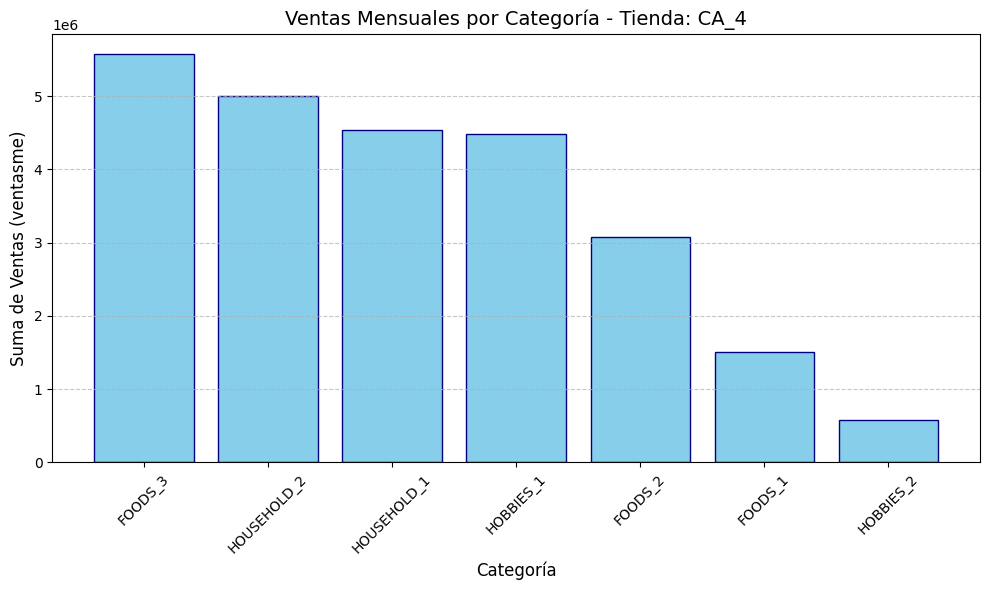

--------------------------------------------------------------------------------------------------------------


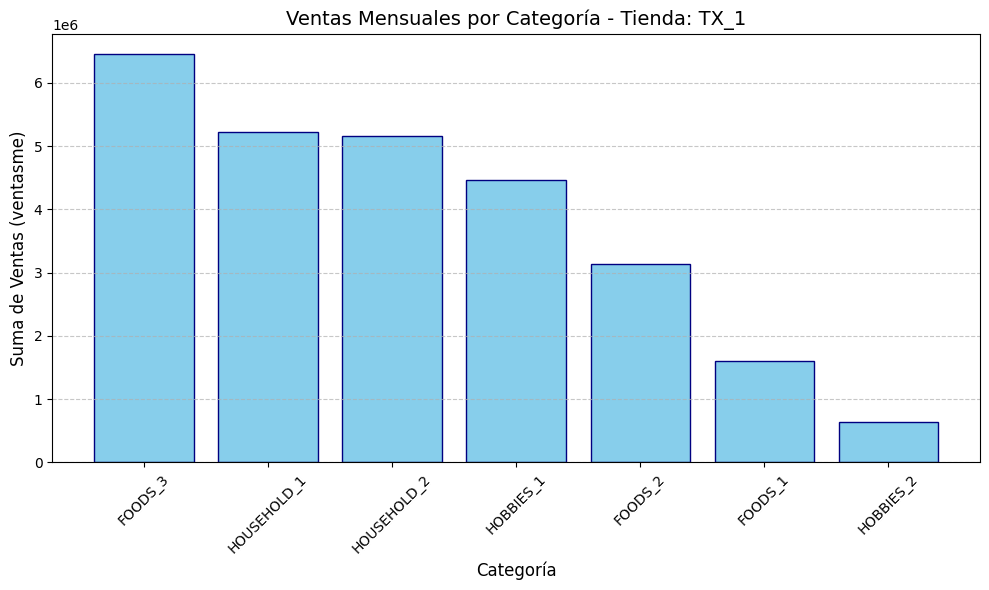

--------------------------------------------------------------------------------------------------------------


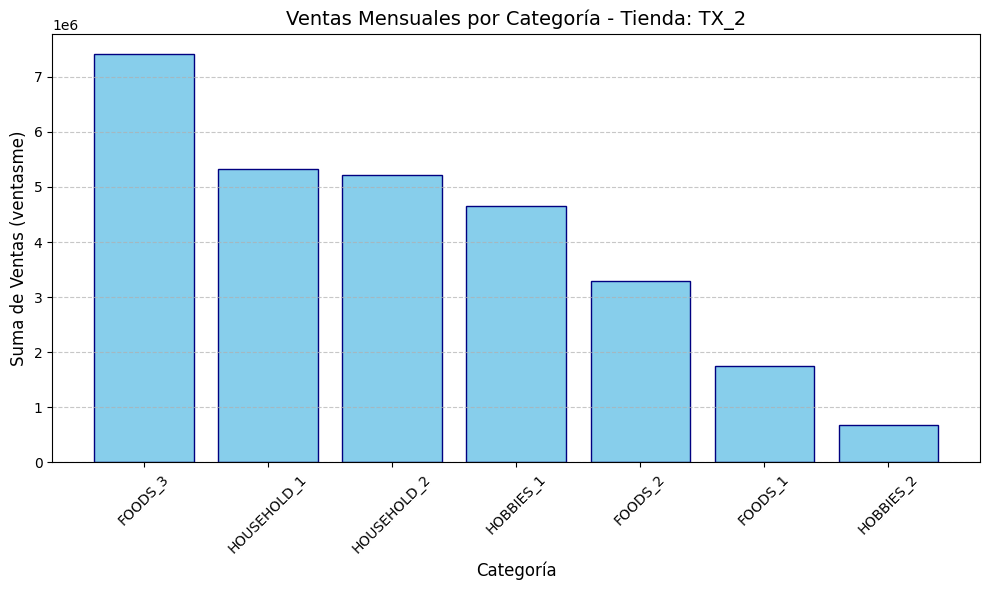

--------------------------------------------------------------------------------------------------------------


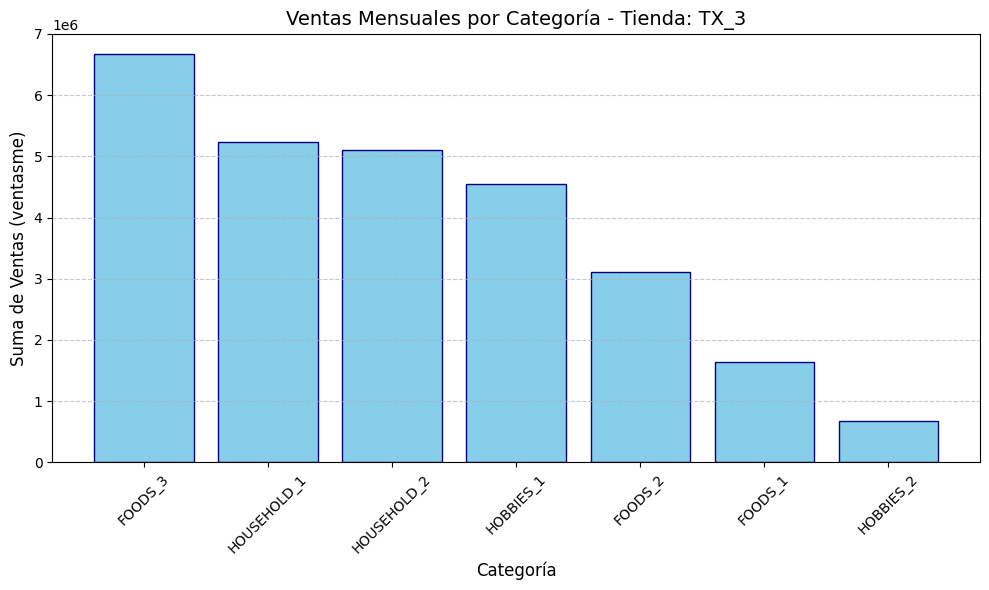

--------------------------------------------------------------------------------------------------------------


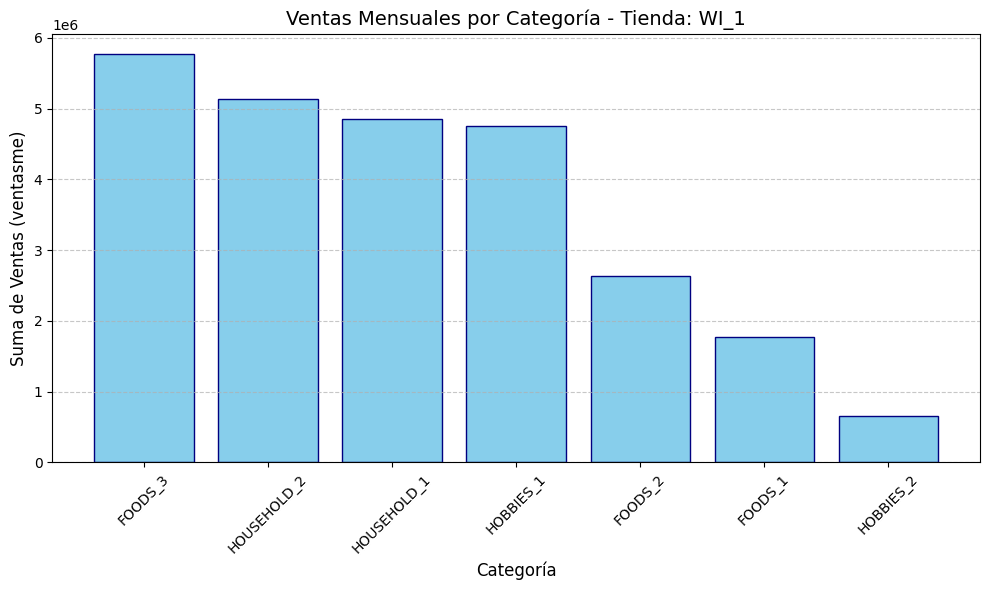

--------------------------------------------------------------------------------------------------------------


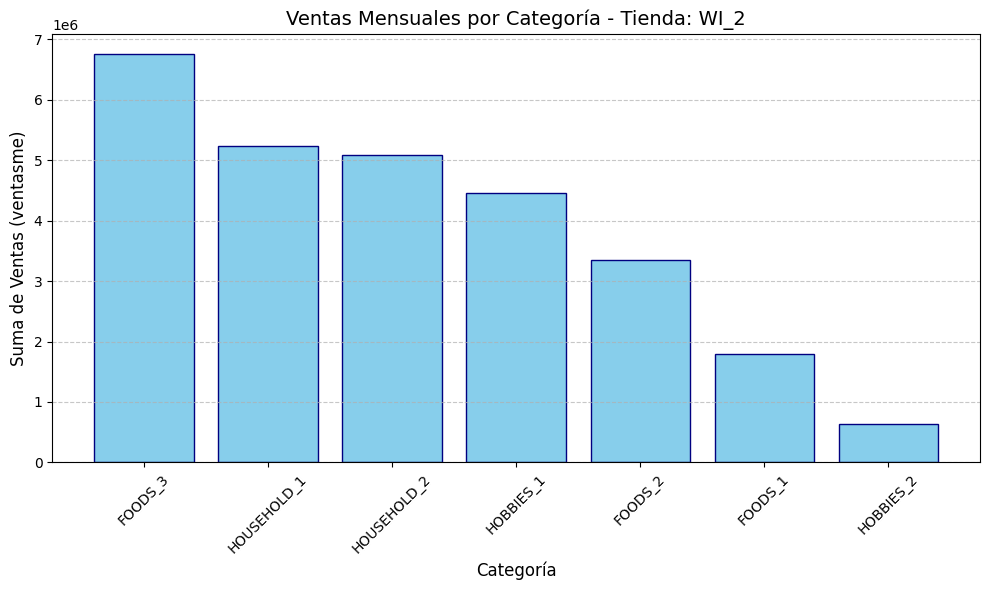

--------------------------------------------------------------------------------------------------------------


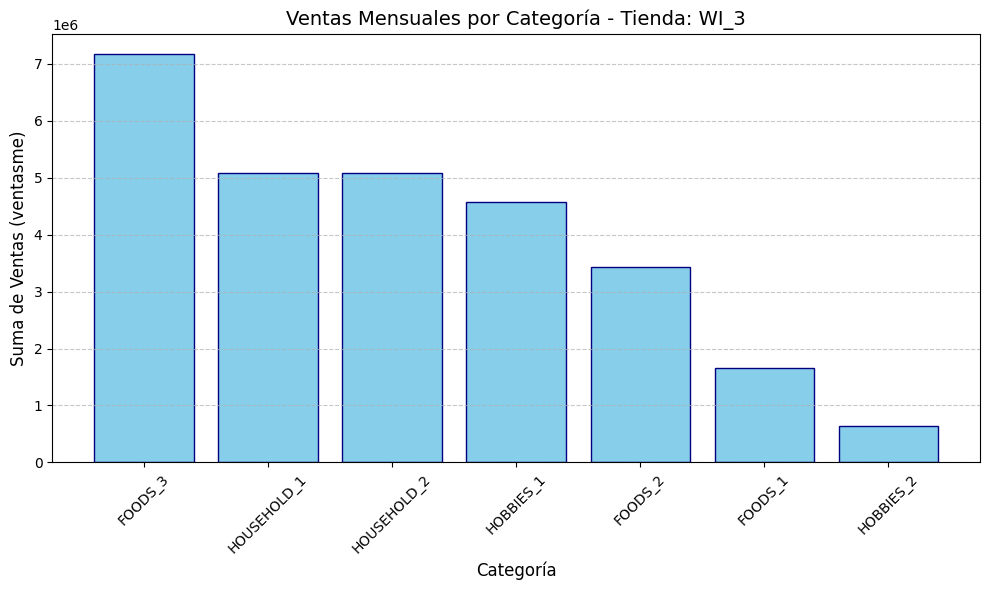

--------------------------------------------------------------------------------------------------------------
Gráficas generadas exitosamente.


In [37]:
tiendas = dept_x_tienda['store_id'].unique()

# 4. Generar un gráfico por cada tienda
for tienda in tiendas:
    # Filtrar datos para la tienda actual
    data_tienda = dept_x_tienda[dept_x_tienda['store_id'] == tienda]
    
    # Ordenar por ventas para una mejor visualización (opcional)
    data_tienda = data_tienda.sort_values(by='ventasme', ascending=False)
    
    # Crear la figura
    plt.figure(figsize=(10, 6))
    plt.bar(data_tienda['dept_id'], data_tienda['ventasme'], color='skyblue', edgecolor='navy')
    
    # Añadir títulos y etiquetas
    plt.title(f'Ventas Mensuales por Categoría - Tienda: {tienda}', fontsize=14)
    plt.xlabel('Categoría', fontsize=12)
    plt.ylabel('Suma de Ventas (ventasme)', fontsize=12)
    plt.xticks(rotation=45) # Rotar etiquetas si son largas
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar diseño para que no se corten las etiquetas
    plt.tight_layout()
    plt.show()
    # Guardar el gráfico
    print("-" * 110) # Cerrar la figura para liberar memoria

print("Gráficas generadas exitosamente.")

## Productos por tienda

In [38]:
item_x_tienda = sales_long.groupby(['store_id', 'item_id']).agg({'ventasme' : 'sum'}).reset_index()

item_x_tienda['ranking'] = item_x_tienda.groupby('store_id')['ventasme'].rank(ascending=False, method='min')
item_x_tienda = item_x_tienda[item_x_tienda['ranking'] <= 20]
item_x_tienda

,store_id,item_id,ventasme,ranking
234,CA_1,FOODS_2_019,41983.22,14.0
411,CA_1,FOODS_2_197,47578.66,9.0
692,CA_1,FOODS_3_080,42767.98,13.0
695,CA_1,FOODS_3_083,39022.93,17.0
702,CA_1,FOODS_3_090,131543.19,1.0
...,...,...,...,...
28936,WI_3,HOBBIES_1_060,43533.95,15.0
29095,WI_3,HOBBIES_1_225,43632.16,12.0
29230,WI_3,HOBBIES_1_361,43389.65,16.0
30184,WI_3,HOUSEHOLD_2_211,38467.08,20.0


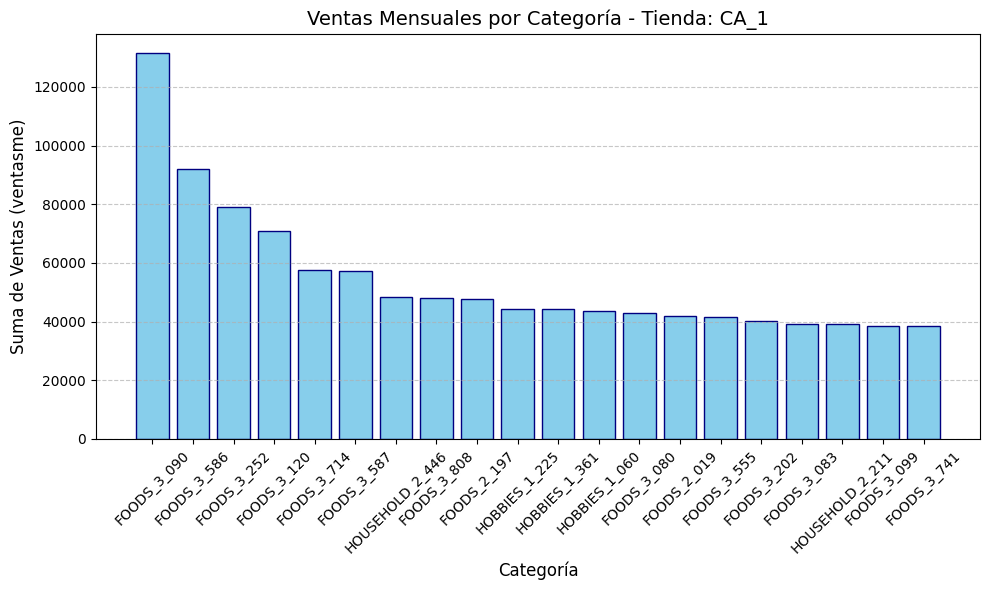

----------------------------------------------------------------------------------------------------------------------------------


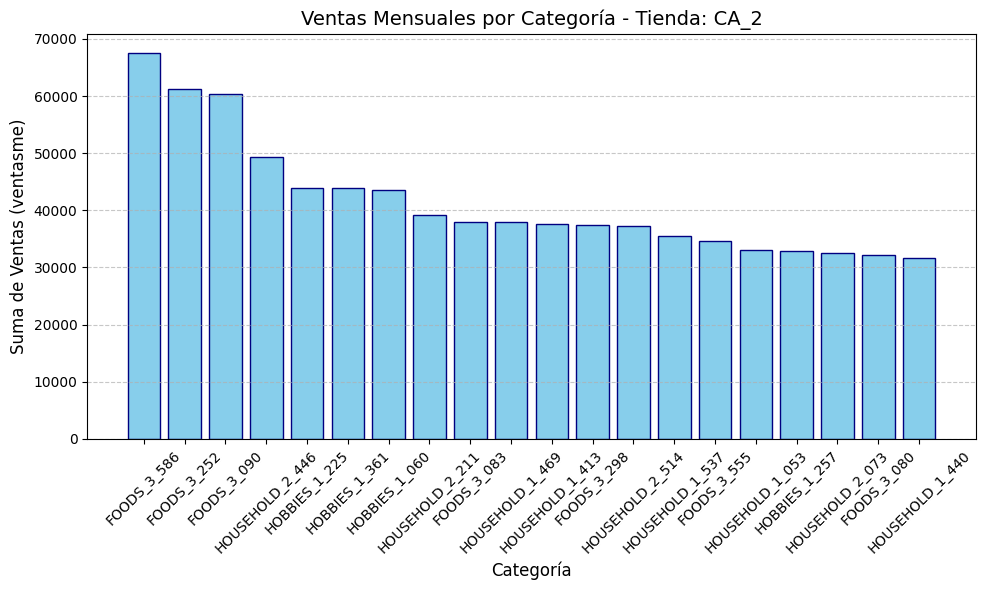

----------------------------------------------------------------------------------------------------------------------------------


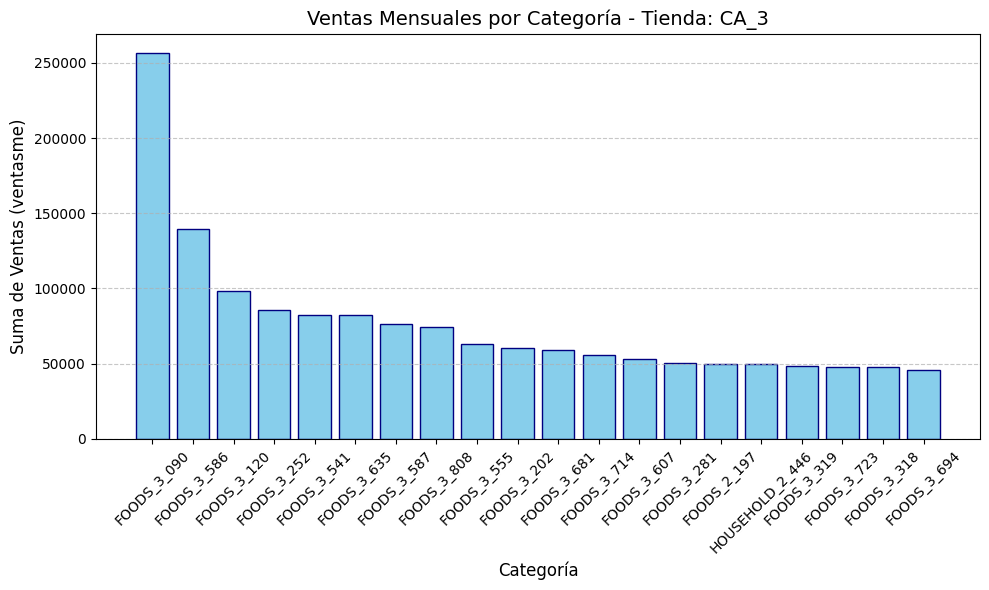

----------------------------------------------------------------------------------------------------------------------------------


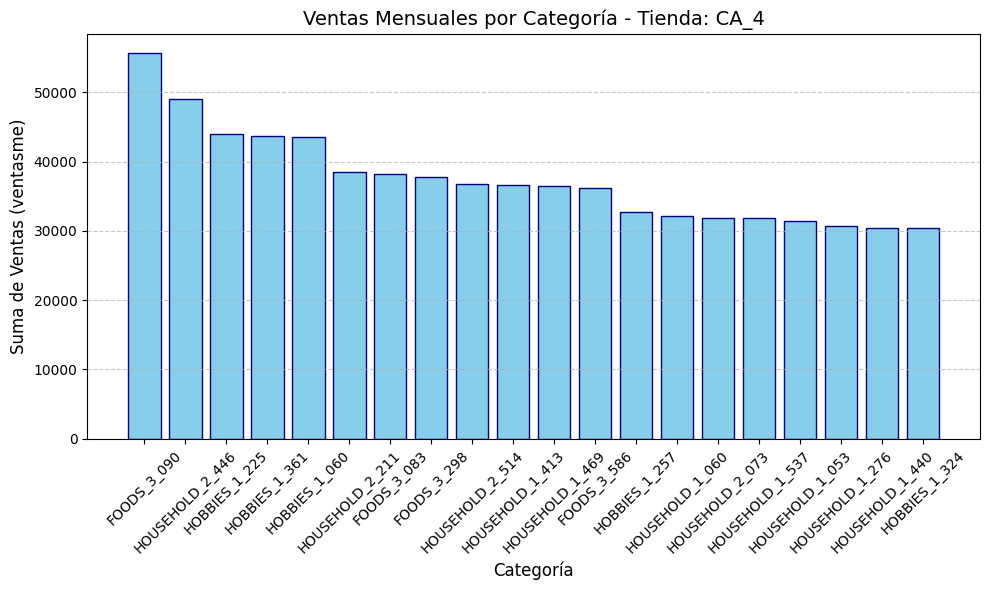

----------------------------------------------------------------------------------------------------------------------------------


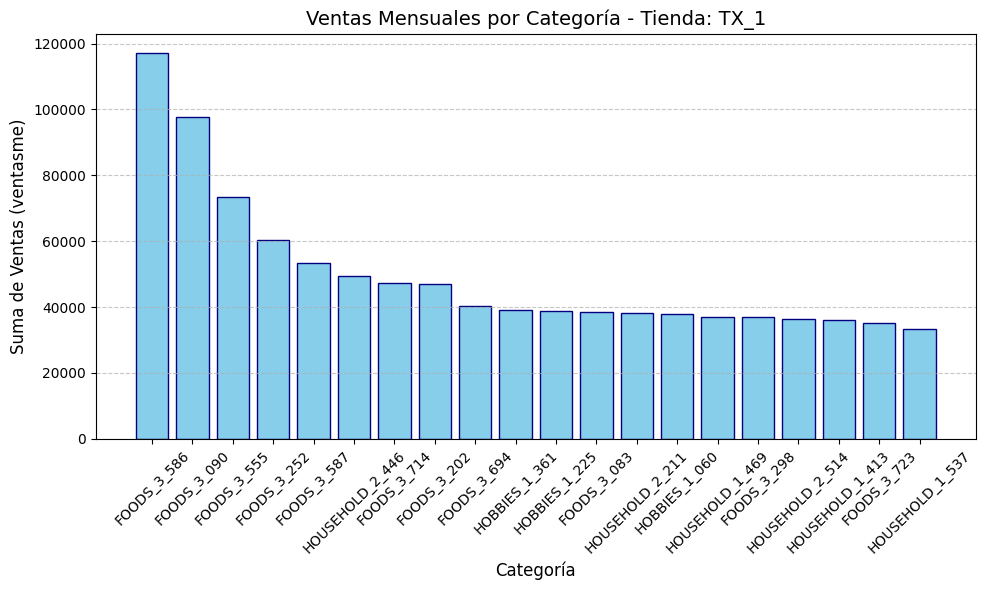

----------------------------------------------------------------------------------------------------------------------------------


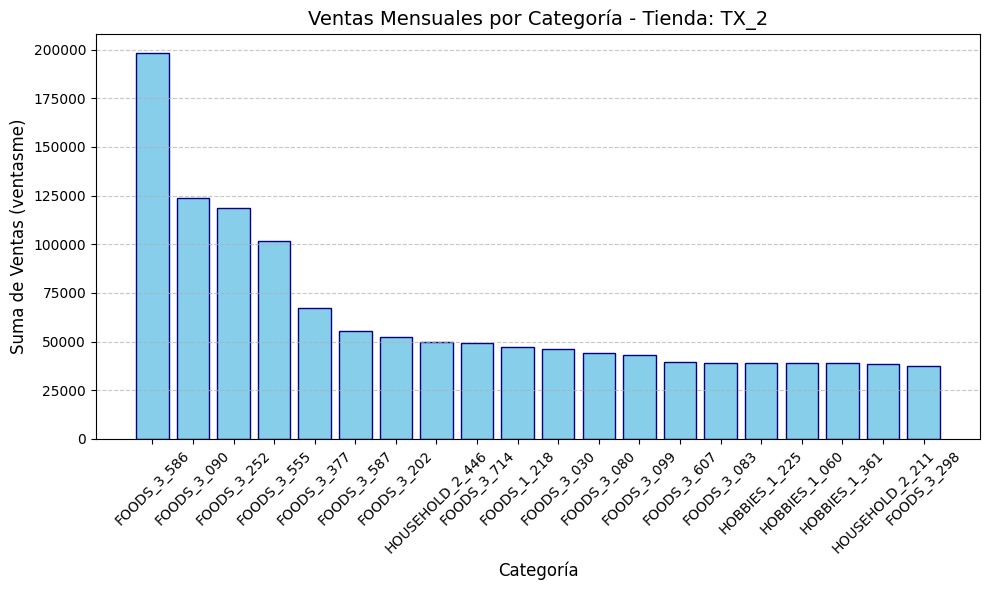

----------------------------------------------------------------------------------------------------------------------------------


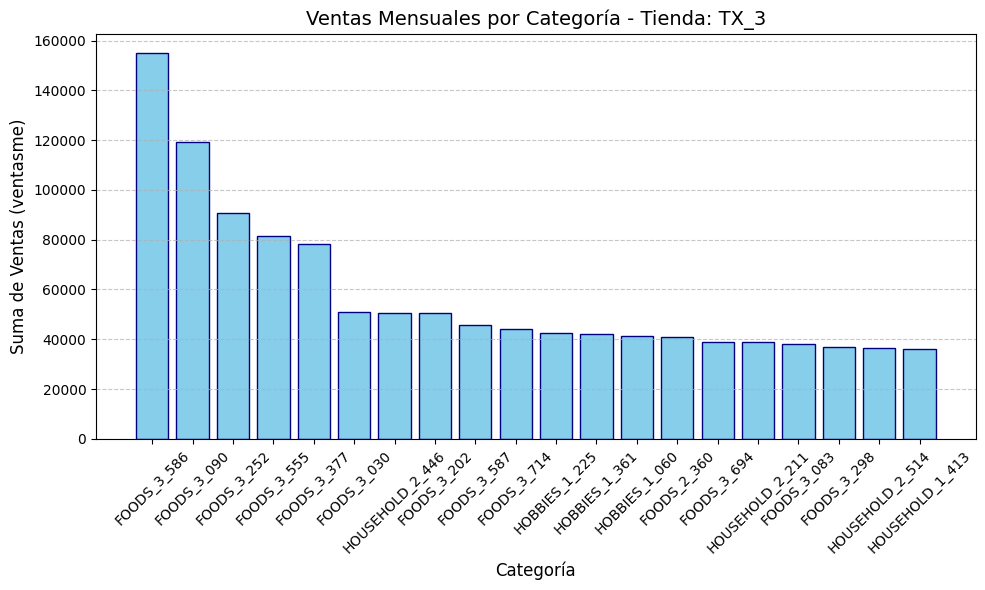

----------------------------------------------------------------------------------------------------------------------------------


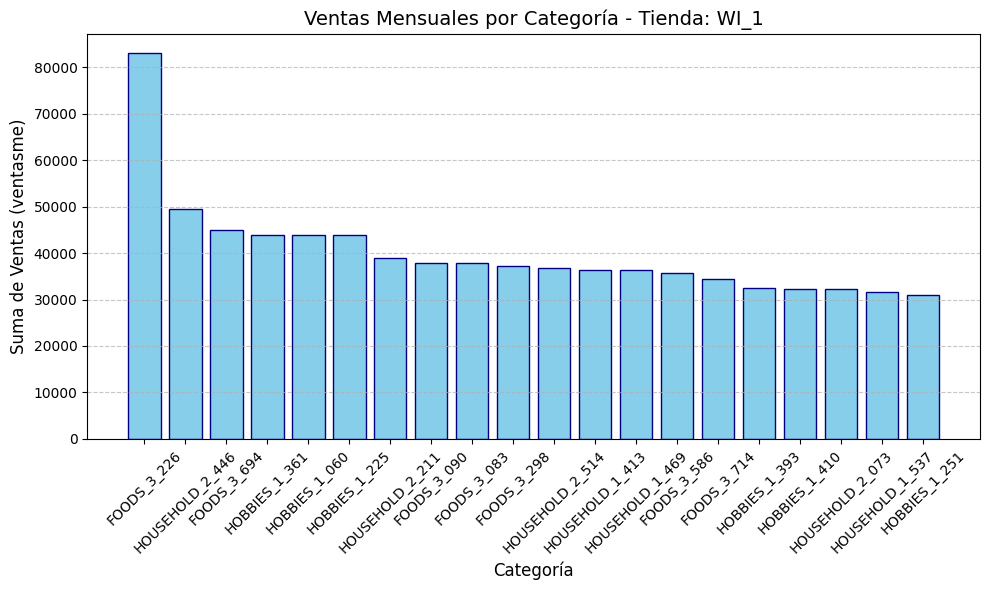

----------------------------------------------------------------------------------------------------------------------------------


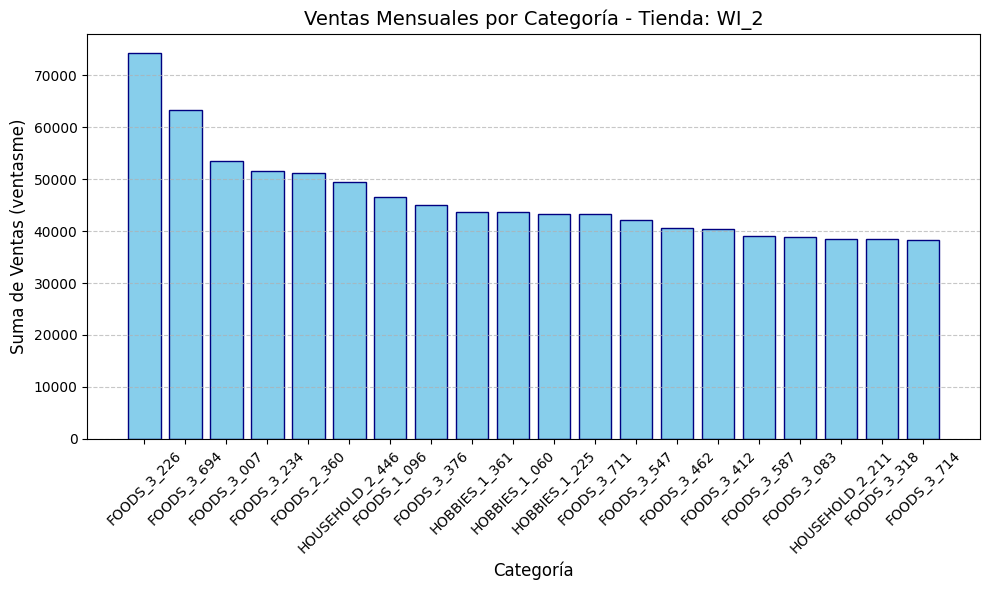

----------------------------------------------------------------------------------------------------------------------------------


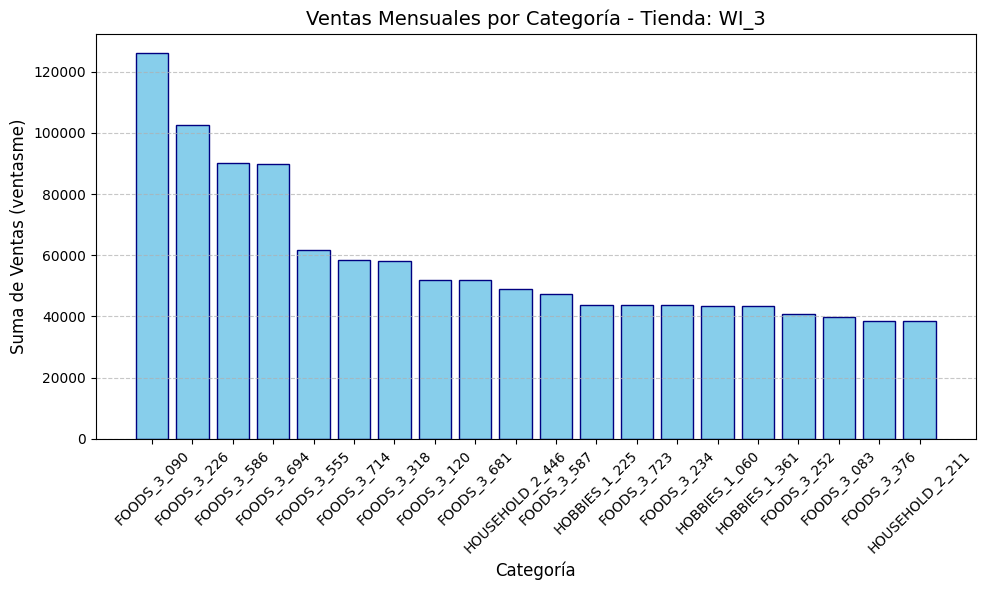

----------------------------------------------------------------------------------------------------------------------------------
Gráficas generadas exitosamente.


In [39]:
tiendas = item_x_tienda['store_id'].unique()

# 4. Generar un gráfico por cada tienda
for tienda in tiendas:
    # Filtrar datos para la tienda actual
    data_tienda = item_x_tienda[item_x_tienda['store_id'] == tienda]
    
    # Ordenar por ventas para una mejor visualización (opcional)
    data_tienda = data_tienda.sort_values(by='ventasme', ascending=False)
    
    # Crear la figura
    plt.figure(figsize=(10, 6))
    plt.bar(data_tienda['item_id'], data_tienda['ventasme'], color='skyblue', edgecolor='navy')
    
    # Añadir títulos y etiquetas
    plt.title(f'Ventas Mensuales por Categoría - Tienda: {tienda}', fontsize=14)
    plt.xlabel('Categoría', fontsize=12)
    plt.ylabel('Suma de Ventas (ventasme)', fontsize=12)
    plt.xticks(rotation=45) # Rotar etiquetas si son largas
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar diseño para que no se corten las etiquetas
    plt.tight_layout()
    plt.show()
    # Guardar el gráfico
    print("-" * 130) # Cerrar la figura para liberar memoria

print("Gráficas generadas exitosamente.")

## Calcular días promedio entre compras

In [16]:
# 1. Convertir la columna date a formato fecha
sales_long['date'] = pd.to_datetime(sales_long['date'])

# 2. Filtrar solo los días con compras (cantidad > 0)
compras = sales_long[sales_long['cantidad'] > 0].copy()

# 3. Ordenar por item, tienda y fecha para calcular los intervalos correctamente
compras = compras.sort_values(by=['item_id', 'store_id', 'date'])

# 4. Calcular la diferencia en días entre compras consecutivas para cada item en cada tienda
compras['dias_entre_compras'] = compras.groupby(['item_id', 'store_id'])['date'].diff().dt.days

# 5. Calcular el promedio de días entre compras
# Nota: La primera compra de cada grupo resultará en NaN (no tiene compra anterior), 
# por lo que el promedio ignorará automáticamente esos valores.
dias_entre_compras = compras.groupby(['item_id', 'store_id'])['dias_entre_compras'].mean().reset_index()
dias_entre_compras['ranking'] = dias_entre_compras.groupby('store_id')['dias_entre_compras'].rank(ascending=True, method='min')
# dias_entre_compras = dias_entre_compras[dias_entre_compras['ranking'] <= 20].reset_index()

# Renombrar columna para mayor claridad
dias_entre_compras.rename(columns={'dias_entre_compras': 'promedio_dias_entre_compras'}, inplace=True)

dias_entre_compras

,item_id,store_id,promedio_dias_entre_compras,ranking
0,FOODS_1_001,CA_1,2.292308,1462.0
1,FOODS_1_001,CA_2,1.940941,999.0
2,FOODS_1_001,CA_3,2.224771,1715.0
3,FOODS_1_001,CA_4,3.879760,1786.0
4,FOODS_1_001,TX_1,3.024961,1400.0
...,...,...,...,...
30485,HOUSEHOLD_2_516,TX_2,4.847500,2370.0
30486,HOUSEHOLD_2_516,TX_3,8.622222,2686.0
30487,HOUSEHOLD_2_516,WI_1,12.324841,2933.0
30488,HOUSEHOLD_2_516,WI_2,31.098361,3024.0


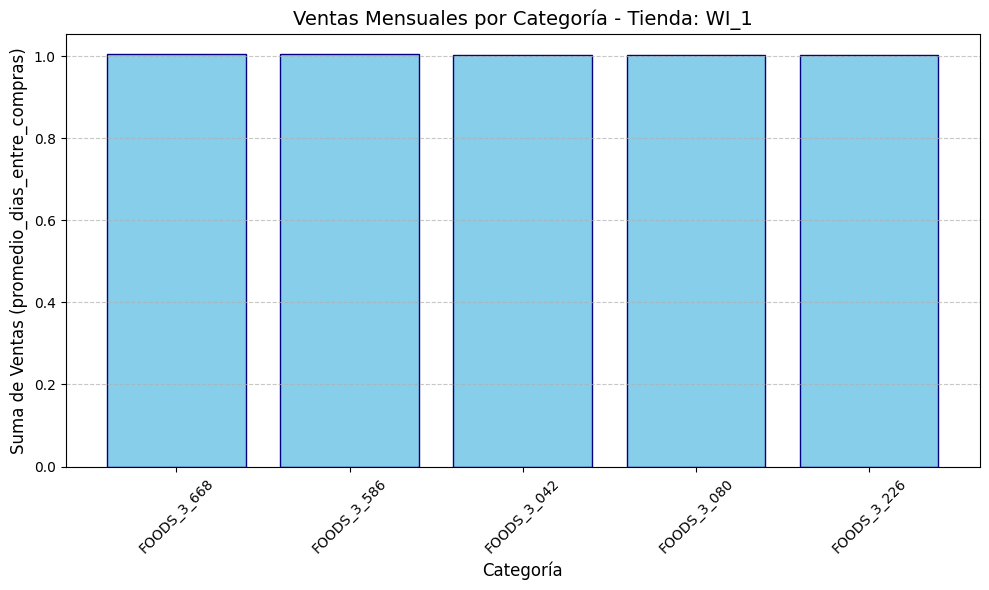

----------------------------------------------------------------------------------------------------------------------------------


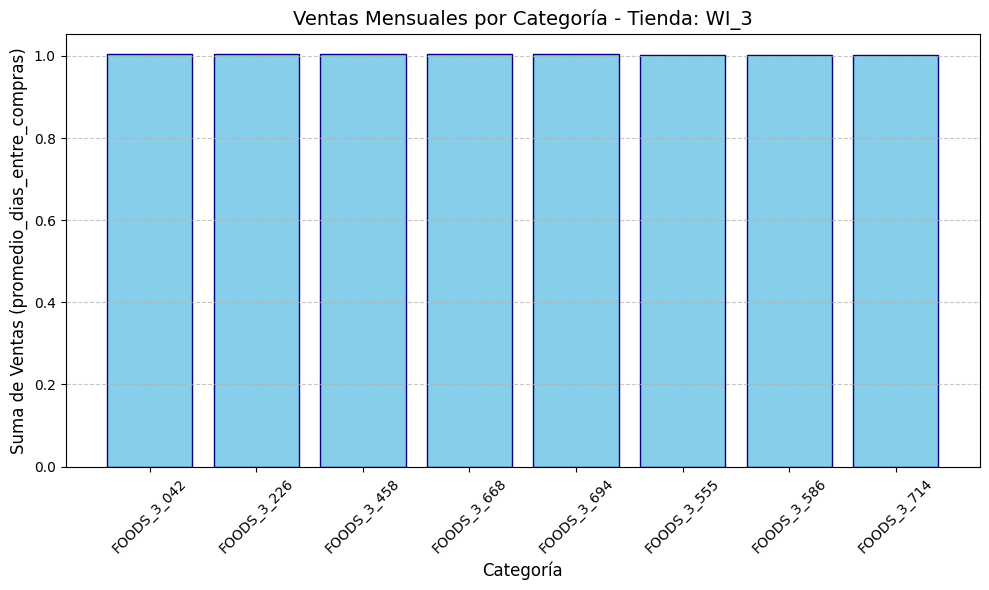

----------------------------------------------------------------------------------------------------------------------------------


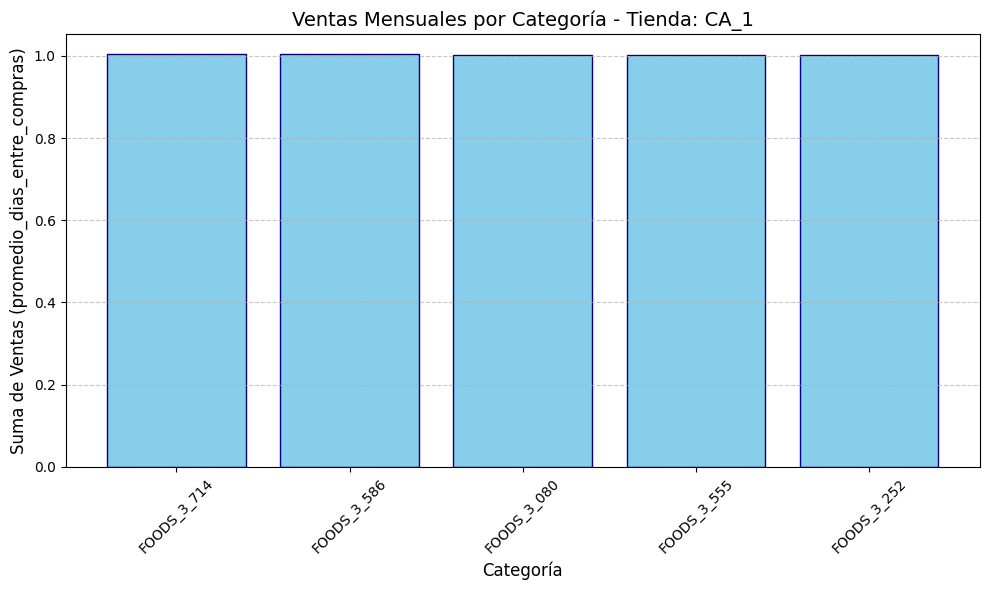

----------------------------------------------------------------------------------------------------------------------------------


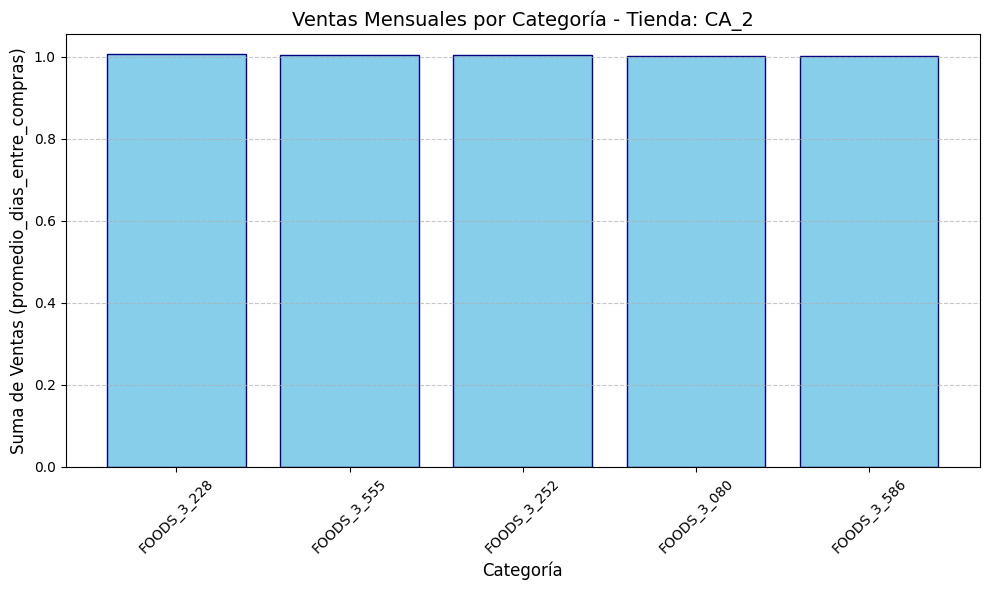

----------------------------------------------------------------------------------------------------------------------------------


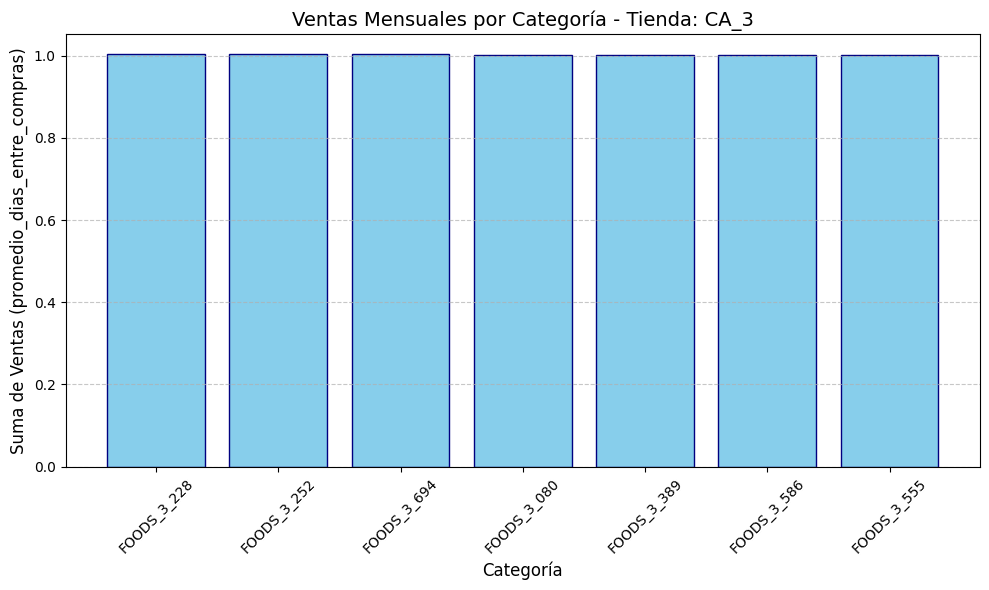

----------------------------------------------------------------------------------------------------------------------------------


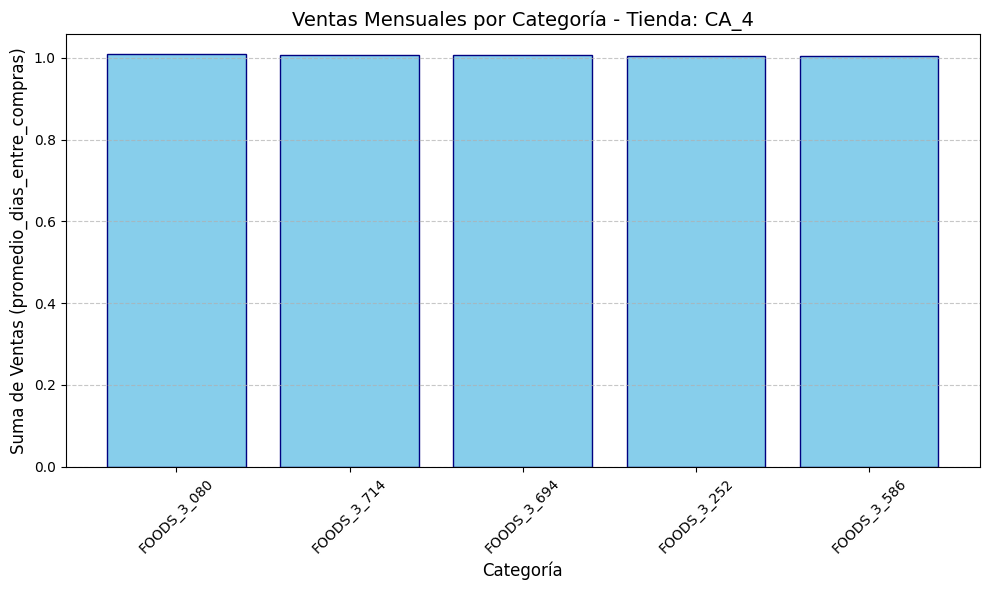

----------------------------------------------------------------------------------------------------------------------------------


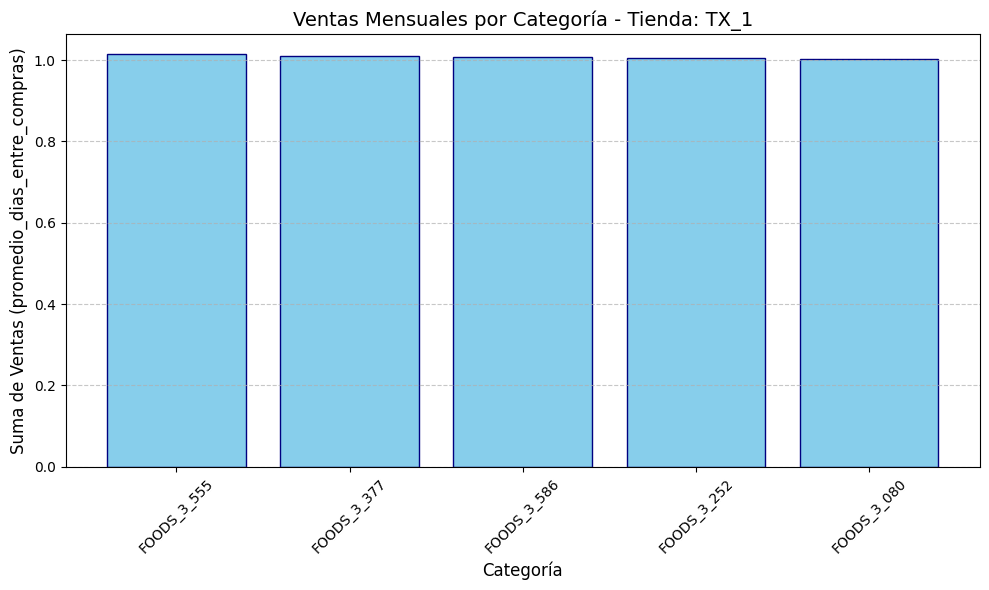

----------------------------------------------------------------------------------------------------------------------------------


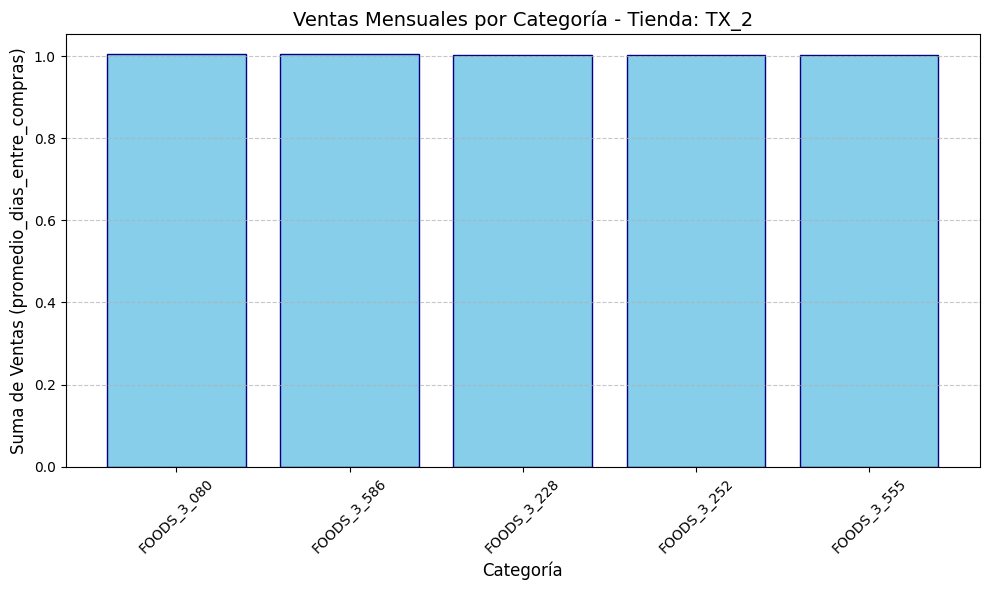

----------------------------------------------------------------------------------------------------------------------------------


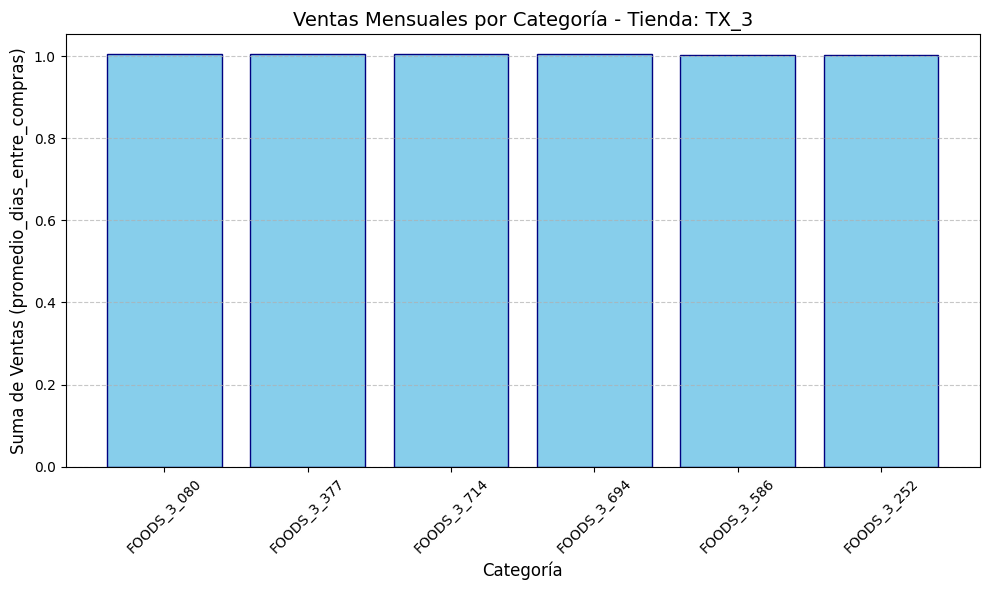

----------------------------------------------------------------------------------------------------------------------------------


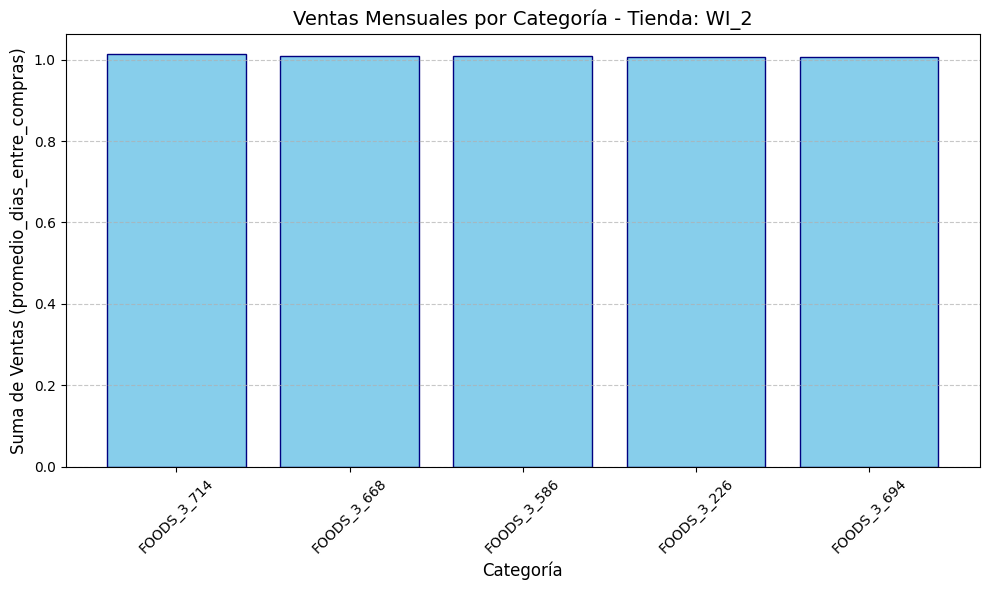

----------------------------------------------------------------------------------------------------------------------------------
Gráficas generadas exitosamente.


In [17]:
dias_entre_compras_grafico = dias_entre_compras[dias_entre_compras['ranking'] <= 5]
tiendas = dias_entre_compras_grafico['store_id'].unique()

# 4. Generar un gráfico por cada tienda
for tienda in tiendas:
    # Filtrar datos para la tienda actual
    data_tienda = dias_entre_compras_grafico[dias_entre_compras_grafico['store_id'] == tienda]
    
    # Ordenar por ventas para una mejor visualización (opcional)
    data_tienda = data_tienda.sort_values(by='promedio_dias_entre_compras', ascending=False)
    
    # Crear la figura
    plt.figure(figsize=(10, 6))
    plt.bar(data_tienda['item_id'], data_tienda['promedio_dias_entre_compras'], color='skyblue', edgecolor='navy')
    
    # Añadir títulos y etiquetas
    plt.title(f'Ventas Mensuales por Categoría - Tienda: {tienda}', fontsize=14)
    plt.xlabel('Categoría', fontsize=12)
    plt.ylabel('Suma de Ventas (promedio_dias_entre_compras)', fontsize=12)
    plt.xticks(rotation=45) # Rotar etiquetas si son largas
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar diseño para que no se corten las etiquetas
    plt.tight_layout()
    plt.show()
    # Guardar el gráfico
    print("-" * 130) # Cerrar la figura para liberar memoria

print("Gráficas generadas exitosamente.")

## Cálculo de variables adicionales

In [20]:
# 1. Asegurarse de que 'date' sea formato datetime
sales_long['date'] = pd.to_datetime(sales_long['date'])

# 2. Ordenar por ID y fecha para asegurar la cronología
sales_long = sales_long.sort_values(by=['item_id', 'store_id', 'date'])

# 3. Crear una columna que solo tenga la fecha cuando hubo una compra (cantidad > 0)
# Usamos .where para dejar NaN donde la cantidad es 0
sales_long['last_purchase_date'] = sales_long['date'].where(sales_long['cantidad'] > 0)

# 4. Agrupar por producto y tienda, y propagar la última fecha hacia adelante
# Usamos shift(1) para que el día de la compra no se cuente a sí mismo como "última compra"
sales_long['last_purchase_date'] = sales_long.groupby(['item_id', 'store_id'])['last_purchase_date'].ffill().shift(1)

# 5. Calcular la diferencia en días
sales_long['days_since_last_purchase'] = (sales_long['date'] - sales_long['last_purchase_date']).dt.days

# Opcional: Rellenar con un valor (ej. -1 o 0) si nunca ha habido una compra previa
sales_long['days_since_last_purchase'] = sales_long['days_since_last_purchase'].fillna(-1)

In [47]:
sales_long.head(5)

,item_id,dept_id,cat_id,store_id,state_id,cantidad,date,d,wm_yr_wk,event_name_1,...,snap_WI,sell_price,ventasme,dias_desde_ultima_compra,compra,cantidad_ultima_compra,promedio_dias_entre_compras,promedio_cantidad,last_purchase_date,days_since_last_purchase
0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,d_1,11101,NaN,...,0,2.0,5.0,-1,1,NaN,2.292308,1.803783,NaT,-1.0
1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,d_2,11101,NaN,...,0,2.0,2.0,1,0,3.0,2.292308,1.803783,2011-01-29,1.0
2,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,d_3,11101,NaN,...,0,2.0,2.0,2,0,NaN,2.292308,1.803783,2011-01-29,2.0
3,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,d_4,11101,NaN,...,0,2.0,3.0,3,1,NaN,2.292308,1.803783,2011-01-29,3.0
4,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,d_5,11101,NaN,...,1,2.0,6.0,1,1,1.0,2.292308,1.803783,2011-02-01,1.0


In [48]:
dias_entre_compras.head(5)

,item_id,store_id,promedio_dias_entre_compras,ranking
0,FOODS_1_001,CA_1,2.292308,1462.0
1,FOODS_1_001,CA_2,1.940941,999.0
2,FOODS_1_001,CA_3,2.224771,1715.0
3,FOODS_1_001,CA_4,3.879760,1786.0
4,FOODS_1_001,TX_1,3.024961,1400.0


In [21]:
sales_long = sales_long.merge(
    dias_entre_compras,
    on=['item_id', 'store_id'],
    how='inner'
)

sales_long = sales_long[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'cantidad',
       'date', 'd', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price',
       'ventasme', 'last_purchase_date', 'days_since_last_purchase','promedio_dias_entre_compras']].reset_index()

In [51]:
sales_long.head(5)

,index,item_id,dept_id,cat_id,store_id,state_id,cantidad,date,d,wm_yr_wk,...,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,ventasme,last_purchase_date,days_since_last_purchase,promedio_dias_entre_compras
0,0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,d_1,11101,...,NaN,NaN,0,0,0,2.0,5.0,NaT,-1.0,2.292308
1,1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,d_2,11101,...,NaN,NaN,0,0,0,2.0,2.0,2011-01-29,1.0,2.292308
2,2,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,d_3,11101,...,NaN,NaN,0,0,0,2.0,2.0,2011-01-29,2.0,2.292308
3,3,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,d_4,11101,...,NaN,NaN,1,1,0,2.0,3.0,2011-01-29,3.0,2.292308
4,4,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,d_5,11101,...,NaN,NaN,1,0,1,2.0,6.0,2011-02-01,1.0,2.292308


In [60]:
sales_long.columns

Index(['index', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'cantidad', 'date', 'd', 'wm_yr_wk', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'ventasme', 'last_purchase_date',
       'days_since_last_purchase', 'promedio_dias_entre_compras'],
      dtype='str')

In [22]:
# Suponiendo que tu dataframe se llama df
sales_long['promedio_item_tienda'] = sales_long.groupby(['item_id', 'store_id'])['cantidad'].transform('mean')

In [23]:
sales_long['compra'] = (sales_long['cantidad'] > 0).astype(int)

In [24]:
sales_long.columns

Index(['index', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'cantidad', 'date', 'd', 'wm_yr_wk', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'ventasme', 'last_purchase_date',
       'days_since_last_purchase', 'promedio_dias_entre_compras',
       'promedio_item_tienda', 'compra'],
      dtype='str')

## Desbalanceo en la muestra

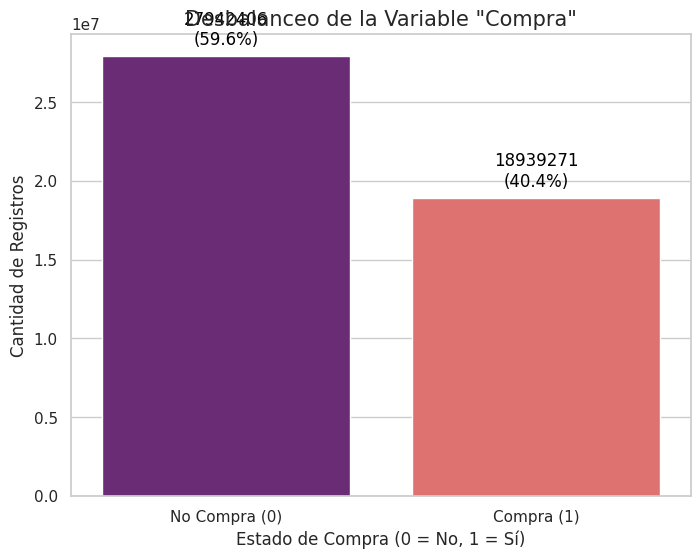

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del estilo
sns.set_theme(style="whitegrid")

# Crear el gráfico
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='compra', data=sales_long, palette='magma')

# Calcular porcentajes y añadir etiquetas sobre las barras
total = len(sales_long)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(f'{int(height)}\n({percentage})', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Personalización de títulos y etiquetas
plt.title('Desbalanceo de la Variable "Compra"', fontsize=15)
plt.xlabel('Estado de Compra (0 = No, 1 = Sí)', fontsize=12)
plt.ylabel('Cantidad de Registros', fontsize=12)
plt.xticks([0, 1], ['No Compra (0)', 'Compra (1)'])

# Mostrar el gráfico
plt.show()

# Cross validation test

In [51]:
def cross_validation(df, sample_size=None):
    target = 'compra'

    # Opcional: Submuestreo para no saturar la RAM durante la comparación inicial
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42, stratify=df[target])

    categorical_features = ['dept_id', 'cat_id', 'store_id', 'state_id', 
                            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    numeric_features = ['wm_yr_wk', 'snap_CA', 'snap_TX', 'snap_WI', 
                        'sell_price', 'days_since_last_purchase', 'promedio_dias_entre_compras', 'promedio_item_tienda']

    X = df[categorical_features + numeric_features]
    y = df[target]

    # IMPORTANTE: Liberar el DF original si ya no se usa
    del df
    gc.collect()

    # Pre-transformación mínima (especialmente para modelos que no aceptan strings)
    # Nota: Para LightGBM/CatBoost podrías saltarte el OneHot si usas sus tipos nativos
    for col in categorical_features:
        X[col] = X[col].astype('category').cat.codes.astype('int16')

    # Configuración de modelos con parámetros de bajo consumo
    models = {
        "Logistic Regression": LogisticRegression(max_iter=200, class_weight='balanced'),
        "LightGBM": LGBMClassifier(class_weight='balanced', n_jobs=-1, n_estimators=100),
        "XGBoost": XGBClassifier(n_jobs=-1, n_estimators=100, tree_method='hist') # 'hist' es más eficiente en RAM
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    print(f"{'Modelo':<25} | {'Precision':<10} | {'Recall':<10} | {'F1':<10}")
    
    for name, model in models.items():
        # Ejecutar CV de forma secuencial (n_jobs=1) para ahorrar RAM
        cv_results = cross_validate(
            model, X, y, cv=skf, 
            scoring={'p': 'precision', 'r': 'recall', 'f1': 'f1'},
            n_jobs=1 
        )
        
        print(f"{name:<25} | {np.mean(cv_results['test_p']):.4f} | {np.mean(cv_results['test_r']):.4f} | {np.mean(cv_results['test_f1']):.4f}")
        
        gc.collect() # Limpiar después de cada modelo

In [52]:
cross_validation(sales_long)

Modelo                    | Precision  | Recall     | F1        
Logistic Regression       | 0.6181 | 0.8170 | 0.7038
LightGBM                  | 0.6759 | 0.7685 | 0.7193
XGBoost                   | 0.7355 | 0.6647 | 0.6983


In [29]:
def objective(trial, X_train, y_train, X_val, y_val, cat_features):
    # 1. Definir el espacio de búsqueda de hiperparámetros
    params = {
        'objective': 'binary',
        'metric': 'custom', # Usaremos F1 personalizado
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
    }

    # 2. Entrenamiento
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        categorical_feature=cat_features,
        callbacks=[lgb.log_evaluation(0)]
    )

    # 3. Predicción y Cálculo de F1
    preds = model.predict(X_val)
    score = f1_score(y_val, preds)
    
    return score

In [30]:
categorical_features = ['dept_id', 'cat_id', 'store_id', 'state_id', 
                            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

numeric_features = ['wm_yr_wk', 'snap_CA', 'snap_TX', 'snap_WI', 
                        'sell_price', 'days_since_last_purchase', 'promedio_dias_entre_compras', 'promedio_item_tienda']

target = 'compra'

for col in categorical_features:
    sales_long[col] = sales_long[col].astype('category')

X = sales_long[categorical_features + numeric_features]
y = sales_long[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False)

# Optimización de hiperparametros

In [33]:
study = optuna.create_study(direction='maximize') # Queremos maximizar el F1

default_params = {
    'learning_rate': 0.1,       # Valor típico inicial
    'num_leaves': 31,           # Default de LightGBM
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'min_child_samples': 20,
    'lambda_l1': 1e-8,
    'lambda_l2': 1e-8
}

# 3. "Encolar" este trial
study.enqueue_trial(default_params)
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, categorical_features), n_trials=50)

print(f"Mejor F1-Score: {study.best_value}")
print(f"Mejores parámetros: {study.best_params}")

[I 2026-01-20 22:27:55,960] A new study created in memory with name: no-name-38fac43f-072b-4b9a-91fe-146bcf679d12
[I 2026-01-20 22:28:25,314] Trial 0 finished with value: 0.6156270808072659 and parameters: {'learning_rate': 0.1, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'lambda_l1': 1e-08, 'lambda_l2': 1e-08}. Best is trial 0 with value: 0.6156270808072659.
[I 2026-01-20 22:29:24,978] Trial 1 finished with value: 0.5385100625610854 and parameters: {'learning_rate': 0.006630396475734232, 'num_leaves': 253, 'feature_fraction': 0.45127852756053727, 'bagging_fraction': 0.8480491688948599, 'bagging_freq': 3, 'min_child_samples': 7, 'lambda_l1': 1.6762909614345966e-05, 'lambda_l2': 1.376763244446847e-05}. Best is trial 0 with value: 0.6156270808072659.
[I 2026-01-20 22:30:22,389] Trial 2 finished with value: 0.5772375307084128 and parameters: {'learning_rate': 0.00789894963628542, 'num_leaves': 218, 'feature_fraction': 0.9

Mejor F1-Score: 0.6178716164015151
Mejores parámetros: {'learning_rate': 0.05002501293638256, 'num_leaves': 42, 'feature_fraction': 0.5660815693867214, 'bagging_fraction': 0.766467693985973, 'bagging_freq': 6, 'min_child_samples': 50, 'lambda_l1': 0.033175013802042866, 'lambda_l2': 2.7775092629435204e-05}


In [38]:
params = {'learning_rate': 0.05002501293638256, 'num_leaves': 42, 'feature_fraction': 0.5660815693867214, 'bagging_fraction': 0.766467693985973, 'bagging_freq': 6, 'min_child_samples': 50, 'lambda_l1': 0.033175013802042866, 'lambda_l2': 2.7775092629435204e-05}

model = lgb.LGBMClassifier(class_weight='balanced', n_jobs=-1, n_estimators=100)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=categorical_features,
    callbacks=[lgb.log_evaluation(0)]
)

# 3. Predicción y Cálculo de F1
preds = model.predict(X_test)
score = f1_score(y_test, preds)

print(score)

0.614088166153697


# Binario del modelo

In [39]:
model.booster_.save_model('modelo_lgbm.txt')